# 1. Introducere

## a. Prezentarea setului de date

În cadrul acestui proiect, am ales să lucrez cu setul de date **The Human Freedom Index**, oferit de **Cato Institute** și **Fraser Institute**, disponibil pe platforma Kaggle. Acest set de date evaluează și compară nivelul libertății umane în peste 160 de țări, pe o perioadă extinsă de 21 de ani (2000–2020), și reprezintă una dintre cele mai complete resurse globale privind libertățile personale și economice.

Setul este structurat la nivel **anual**, iar fiecare rând corespunde unei țări într-un anumit an. Sunt incluse peste **140 de variabile**, organizate în jurul a trei dimensiuni principale:

- **Libertăți personale** – exprimare, religie, identitate, libertatea de mișcare, asocieri, siguranță personală;
- **Libertăți economice** – comerț internațional, reglementări guvernamentale, impozite, investiții;
- **Instituții legale** – statul de drept, justiție procedurală, integritate, libertăți constituționale.

Printre cele mai relevante coloane regăsim:
- `countries`, `region`, `year` – pentru localizarea geografică și temporală;
- `hf_score`, `hf_rank` – scorul total al libertății și poziția în clasamentul global;
- numeroși sub-indicatori prefixați cu `pf_` (personal freedom), `ef_` (economic freedom) și `hf_` (human freedom), care oferă o granularitate ridicată în analiza libertății.

Setul conține **3465 de înregistrări** și **141 de coloane**, iar datele sunt în mare parte numerice, dar conțin și variabile categorice. De asemenea, există un procent semnificativ de **valori lipsă**, care vor necesita preprocesare atentă în etapele ulterioare ale proiectului.

**Link către setul de date**: [https://www.kaggle.com/datasets/gsutters/the-human-freedom-index](https://www.kaggle.com/datasets/gsutters/the-human-freedom-index)

---

## b. Enunțarea obiectivelor

Obiectivul general al acestui proiect este construirea unei aplicații de analiză Big Data care să prelucreze, modeleze și interpreteze date globale despre libertatea umană. Proiectul îmbină componente de prelucrare distribuită, Machine Learning, Deep Learning și Streaming în timp real – pentru a arăta cum pot fi extrase insight-uri relevante dintr-un set de date socio-politice complexe.

### Obiective specifice:
1. **Explorarea și curățarea** datelor folosind PySpark și Spark SQL;
2. **Analiza exploratorie** a distribuției libertăților în funcție de regiuni și ani;
3. **Modelarea predictivă**: antrenarea unor algoritmi de Machine Learning pentru a prezice `hf_score` pe baza sub-indicatorilor (`pf_`, `ef_`);
4. **Construcția unui pipeline ML complet** cu Spark MLlib;
5. **Antrenarea unui model de Deep Learning** (cu TensorFlow) ca alternativă de predicție;
6. **Simularea unui flux de date în timp real**, integrat cu predicția automată, prin Spark Streaming și un model ML salvat.

Prin aceste obiective, proiectul nu doar îndeplinește cerințele academice, ci demonstrează și aplicabilitatea tehnologiilor Big Data în domeniul analizei sociale și a politicilor publice.

# 2. Procesarea datelor cu Spark SQL și DataFrames

## 2.1 Curățarea și pregătirea inițială a datelor

### Obiectiv

În această primă etapă de procesare, ne propunem să transformăm datele brute într-un format curat și consistent, care să poată fi utilizat ulterior în analize și modele. Pentru aceasta, vom folosi funcționalitățile oferite de PySpark, atât prin API-ul DataFrame, cât și prin Spark SQL.

Mai exact, vom:
- elimina coloanele complet goale sau cu prea multe valori lipsă;
- converti tipurile de date relevante;
- păstra doar rândurile esențiale pentru analiză (`year`, `hf_score`, `countries`, `region`);
- verifica starea datasetului după curățare.

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import DoubleType, IntegerType

In [36]:
# 1. Inițializăm SparkSession
spark = SparkSession.builder \
    .appName("HumanFreedomIndexProcessing") \
    .getOrCreate()

In [37]:
# 2. Citim setul de date
df = spark.read.csv("dataset/hfi_cc_2022.csv", header=True, inferSchema=True)
print(f"Dimensiune inițială: {df.count()} rânduri, {len(df.columns)} coloane")

Dimensiune inițială: 3465 rânduri, 141 coloane


In [38]:
# 3. Eliminăm coloanele complet nule
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_sums = null_counts.collect()[0].asDict()

In [39]:
cols_to_drop = [k for k, v in null_sums.items() if v == df.count()]
df_cleaned = df.drop(*cols_to_drop)
print(f"Eliminat {len(cols_to_drop)} coloane complet goale")

Eliminat 0 coloane complet goale


In [40]:
# 4. Eliminăm coloanele cu peste 50% valori lipsă
threshold = int(df.count() * 0.5)
cols_many_nulls = [k for k, v in null_sums.items() if v > threshold]
df_cleaned = df_cleaned.drop(*cols_many_nulls)
print(f"Eliminat {len(cols_many_nulls)} coloane cu peste 50% NaN")

Eliminat 5 coloane cu peste 50% NaN


In [41]:
# 5. Conversie tipuri
df_cleaned = df_cleaned.withColumn("year", col("year").cast(IntegerType()))
df_cleaned = df_cleaned.withColumn("hf_score", col("hf_score").cast(DoubleType()))
df_cleaned = df_cleaned.withColumn("hf_rank", col("hf_rank").cast(IntegerType()))

In [42]:
# 6. Eliminăm rândurile esențiale lipsă
essential_cols = ["year", "countries", "region", "hf_score"]
df_cleaned = df_cleaned.dropna(subset=essential_cols)

In [43]:
# 7. Schema și dimensiune finală
df_cleaned.printSchema()
print(f"Dimensiune finală: {df_cleaned.count()} rânduri, {len(df_cleaned.columns)} coloane")

root
 |-- year: integer (nullable = true)
 |-- countries: string (nullable = true)
 |-- region: string (nullable = true)
 |-- hf_score: double (nullable = true)
 |-- hf_rank: integer (nullable = true)
 |-- hf_quartile: double (nullable = true)
 |-- pf_rol_vdem: double (nullable = true)
 |-- pf_rol: double (nullable = true)
 |-- pf_ss_homicide: double (nullable = true)
 |-- pf_ss_homicide_data: double (nullable = true)
 |-- pf_ss_disappearances_disap: double (nullable = true)
 |-- pf_ss_disappearances_violent: double (nullable = true)
 |-- pf_ss_disappearances_violent_data: double (nullable = true)
 |-- pf_ss_disappearances_organized: double (nullable = true)
 |-- pf_ss_disappearances_fatalities: double (nullable = true)
 |-- pf_ss_disappearances_fatalities_data: double (nullable = true)
 |-- pf_ss_disappearances_injuries: double (nullable = true)
 |-- pf_ss_disappearances_injuries_data: double (nullable = true)
 |-- pf_ss_disappearances_torture: double (nullable = true)
 |-- pf_ss_kill

In [44]:
# 8. Verificăm dacă mai sunt lipsuri
df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show(n=1, truncate=False)

+----+---------+------+--------+-------+-----------+-----------+------+--------------+-------------------+--------------------------+----------------------------+---------------------------------+------------------------------+-------------------------------+------------------------------------+-----------------------------+----------------------------------+----------------------------+--------------+--------------------+-----+------------------------+--------------------+----------------------+----------------+---------------+-----------+------------------------+-----------------------+-------------------+-----------------------+-----------+-----------------+-------------------------+-----------------------+-----------------------+-------------------+----------------------------+------------------------+-------------------------+-------------------+-----------------+-----------+---------------------------+--------------------------------+---------------------------+------------------

In [45]:
# 9. Salvăm ca view temporar pentru Spark SQL
df_cleaned.createOrReplaceTempView("freedom")

In [46]:
# 10. Extragere exemplu România
spark.sql("SELECT * FROM freedom WHERE countries = 'Romania'").show(truncate=False)

+----+---------+--------------+--------+-------+-----------+-----------------+-----------------+-----------------+-------------------+--------------------------+----------------------------+---------------------------------+------------------------------+-------------------------------+------------------------------------+-----------------------------+----------------------------------+----------------------------+--------------+--------------------+-----------------+------------------------+--------------------+----------------------+-----------------+-----------------+-----------------+------------------------+-----------------------+-------------------+-----------------------+-----------------+-----------------+-------------------------+-----------------------+-----------------------+-------------------+----------------------------+------------------------+-------------------------+-------------------+-----------------+-----------------+---------------------------+------------------

### Concluzii

Am curățat semnificativ setul de date, păstrând doar coloanele relevante și eliminând valorile lipsă critice. Datasetul rezultat este mult mai ușor de analizat și interpretat, atât din punct de vedere statistic, cât și computațional.

În secțiunea următoare, vom realiza **agregări și grupări** pentru a explora cum evoluează libertatea în diferite regiuni ale lumii.

## 2.2 Analize exploratorii: grupări și agregări relevante

### Obiectiv general

În această secțiune vom realiza mai multe **agregări și grupări semnificative** asupra setului de date, cu scopul de a evidenția:

- care sunt cele mai libere țări din lume (pe medie);
- care țări au înregistrat cele mai mari progrese sau regrese în libertate;
- cum evoluează libertatea în funcție de regiune și timp;
- relația dintre libertatea personală și cea economică;
- țările unde există un dezechilibru major între dimensiunile de libertate;
- clasificarea țărilor în categorii proprii de libertate: înaltă, medie și scăzută.

Pentru fiecare analiză vom utiliza **PySpark DataFrame API** și **Spark SQL**, iar în unele cazuri vom include vizualizări pentru a sprijini interpretarea rezultatelor.

### 2.2.1 Top 10 țări cu cele mai mari scoruri de libertate (medie)

**Obiectiv**: Să identificăm cele mai libere țări din lume pe baza scorului hf_score, calculat ca medie pe toate înregistrările disponibile pentru fiecare țară în perioada analizată.

Această analiză ne va ajuta să înțelegem care state mențin constant un nivel ridicat de libertate umană, indiferent de contextul global sau regional.

Vom realiza agregarea atât cu PySpark DataFrame API, cât și cu Spark SQL, pentru a valida rezultatele și a demonstra versatilitatea platformei Spark. Rezultatul va fi prezentat atât tabelar, cât și vizual.

In [47]:
# 1. Cream o vizualizare temporară pentru Spark SQL
df_cleaned.createOrReplaceTempView("freedom_data")

In [48]:
# 2. Top 10 țări cu cele mai mari scoruri medii - cu PySpark DataFrame API
from pyspark.sql.functions import avg

top10_df = df_cleaned.groupBy("countries") \
    .agg(avg("hf_score").alias("avg_hf_score")) \
    .orderBy(col("avg_hf_score").desc()) \
    .limit(10)

top10_df.show(truncate=False)

+--------------+-----------------+
|countries     |avg_hf_score     |
+--------------+-----------------+
|Switzerland   |9.166666666666666|
|New Zealand   |9.09             |
|Denmark       |8.995714285714287|
|Finland       |8.915238095238097|
|Australia     |8.907619047619047|
|United Kingdom|8.904285714285715|
|Ireland       |8.899047619047618|
|Sweden        |8.88095238095238 |
|Canada        |8.855714285714285|
|United States |8.827142857142857|
+--------------+-----------------+



In [49]:
# 3. Top 10 cu Spark SQL
query = """
SELECT countries, ROUND(AVG(hf_score), 2) AS avg_hf_score
FROM freedom_data
GROUP BY countries
ORDER BY avg_hf_score DESC
LIMIT 10
"""

In [50]:
top10_sql = spark.sql(query)
top10_sql.show(truncate=False)

+--------------+------------+
|countries     |avg_hf_score|
+--------------+------------+
|Switzerland   |9.17        |
|New Zealand   |9.09        |
|Denmark       |9.0         |
|Finland       |8.92        |
|Australia     |8.91        |
|Ireland       |8.9         |
|United Kingdom|8.9         |
|Sweden        |8.88        |
|Canada        |8.86        |
|United States |8.83        |
+--------------+------------+



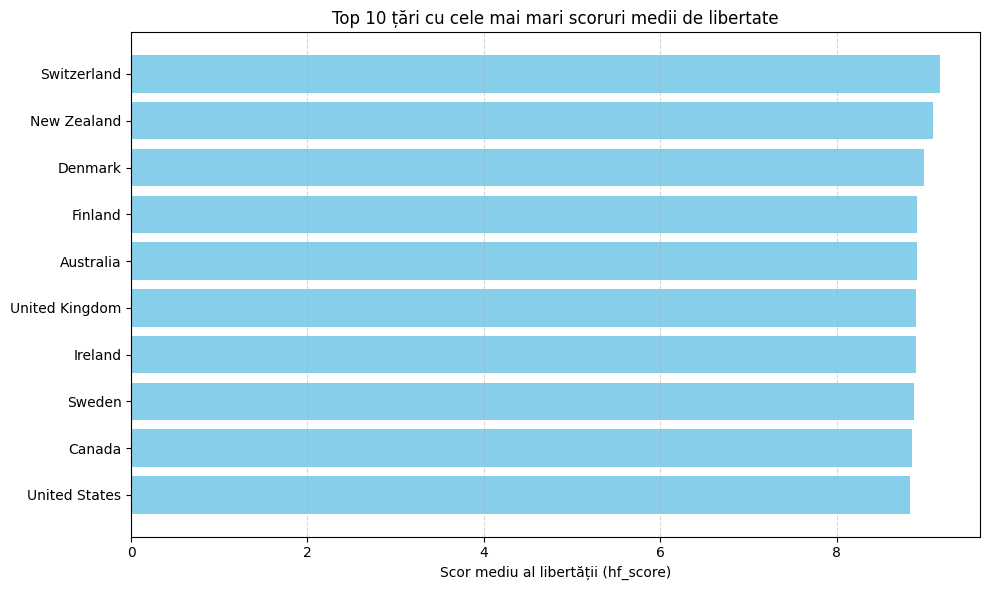

In [51]:
# 4. Vizualizare (cu Matplotlib)
import matplotlib.pyplot as plt

# Convertim rezultatul la Pandas DataFrame
top10_pd = top10_df.toPandas()

# Plot – bară orizontală
plt.figure(figsize=(10, 6))
plt.barh(top10_pd['countries'][::-1], top10_pd['avg_hf_score'][::-1], color='skyblue')
plt.xlabel('Scor mediu al libertății (hf_score)')
plt.title('Top 10 țări cu cele mai mari scoruri medii de libertate')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 2.2.2 Evoluția libertății în 20 de ani: țările cu cele mai mari creșteri și scăderi (2000 vs. 2020)

**Obiectiv**: Să identificăm țările care au înregistrat cele mai semnificative progrese sau regrese în privința libertății umane, comparând scorurile hf_score din anii 2000 și 2020.

Vom calcula diferența dintre scorurile de libertate pentru fiecare țară prezentă în ambii ani, extrăgând:

- Top 10 țări cu cea mai mare creștere a scorului de libertate;

- Top 10 țări cu cea mai mare scădere a acestui scor.

Această analiză oferă o perspectivă clară asupra modului în care evoluțiile geopolitice și economice au influențat nivelul libertății în ultimele două decenii.


In [52]:
from pyspark.sql.functions import col

In [53]:
# 1. Filtrăm doar anii 2000 și 2020 și eliminăm valorile lipsă
df_2000 = df_cleaned.filter(col("year") == 2000) \
    .select("countries", "hf_score") \
    .dropna(subset=["hf_score"]) \
    .withColumnRenamed("hf_score", "hf_score_2000")

df_2020 = df_cleaned.filter(col("year") == 2020) \
    .select("countries", "hf_score") \
    .dropna(subset=["hf_score"]) \
    .withColumnRenamed("hf_score", "hf_score_2020")

In [54]:
# 2. Alăturăm cele două DataFrame-uri după "countries"
df_diff = df_2000.join(df_2020, on="countries", how="inner")

In [55]:
# 3. Calculăm diferența scorurilor
df_diff = df_diff.withColumn("score_change", col("hf_score_2020") - col("hf_score_2000"))

In [56]:
# 4. Top 10 creșteri
top10_up = df_diff.orderBy(col("score_change").desc()).limit(10)
print("Top 10 creșteri între 2000 și 2020:")
top10_up.show(truncate=False)

Top 10 creșteri între 2000 și 2020:
+----------------+-------------+-------------+------------------+
|countries       |hf_score_2000|hf_score_2020|score_change      |
+----------------+-------------+-------------+------------------+
|Myanmar         |3.64         |5.56         |1.9199999999999995|
|Sierra Leone    |5.26         |6.53         |1.2700000000000005|
|Tunisia         |5.27         |6.25         |0.9800000000000004|
|Guinea-Bissau   |5.56         |6.54         |0.9800000000000004|
|Cyprus          |7.32         |8.13         |0.8100000000000005|
|Congo, Dem. Rep.|4.64         |5.39         |0.75              |
|Romania         |7.2          |7.89         |0.6899999999999995|
|Colombia        |5.97         |6.65         |0.6800000000000006|
|Nepal           |6.12         |6.77         |0.6499999999999995|
|Togo            |5.61         |6.25         |0.6399999999999997|
+----------------+-------------+-------------+------------------+



In [57]:
# 5. Top 10 scăderi
top10_down = df_diff.orderBy(col("score_change").asc()).limit(10)
print("Top 10 scăderi între 2000 și 2020:")
top10_down.show(truncate=False)

Top 10 scăderi între 2000 și 2020:
+--------------------+-------------+-------------+-------------------+
|countries           |hf_score_2000|hf_score_2020|score_change       |
+--------------------+-------------+-------------+-------------------+
|Venezuela, RB       |6.43         |4.09         |-2.34              |
|Nicaragua           |7.34         |5.96         |-1.38              |
|Egypt, Arab Rep.    |5.49         |4.28         |-1.21              |
|Syrian Arab Republic|4.47         |3.3          |-1.17              |
|Bolivia             |7.73         |6.6          |-1.1300000000000008|
|El Salvador         |7.74         |6.65         |-1.0899999999999999|
|Argentina           |8.06         |6.99         |-1.0700000000000003|
|Iran, Islamic Rep.  |5.14         |4.26         |-0.8799999999999999|
|Hong Kong SAR, China|8.87         |8.01         |-0.8599999999999994|
|Thailand            |7.35         |6.49         |-0.8599999999999994|
+--------------------+-------------+------

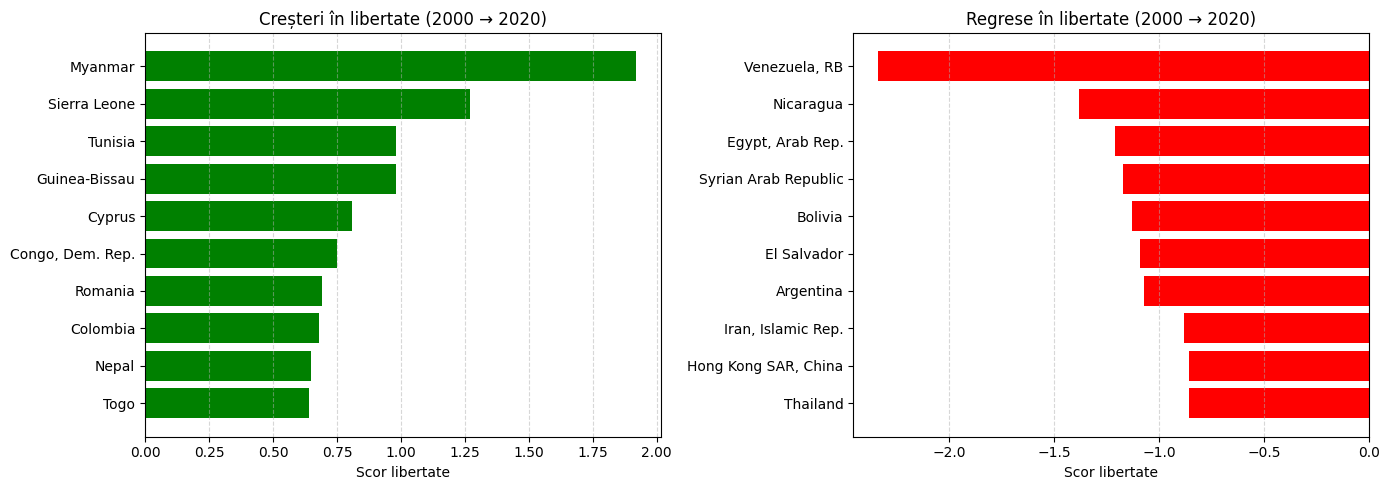

In [59]:
# 6. Vizualizare comparativă
import matplotlib.pyplot as plt

top_up_pd = top10_up.toPandas()
top_down_pd = top10_down.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Creșteri
axes[0].barh(top_up_pd['countries'][::-1], top_up_pd['score_change'][::-1], color='green')
axes[0].set_title('Creșteri în libertate (2000 → 2020)')
axes[0].set_xlabel('Scor libertate')
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# Scăderi
axes[1].barh(top_down_pd['countries'][::-1], top_down_pd['score_change'][::-1], color='red')
axes[1].set_title('Regrese în libertate (2000 → 2020)')
axes[1].set_xlabel('Scor libertate')
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 2.2.3 Evoluția mediei scorului `hf_score` pe regiuni între 2000 și 2020

**Obiectiv**: să analizăm dinamica libertății umane în timp, pe regiuni geografice, prin evoluția scorului mediu hf_score în perioada 2000–2020.

Această analiză evidențiază:

- Regiunile cu îmbunătățiri consistente în libertate;

- Regiunile în care nivelul de libertate a scăzut sau a stagnat;

- Comparații regionale anuale pentru decizii de politică și cercetare.

Vizualizarea sub formă de line chart ajută la înțelegerea clară a tendințelor globale și regionale.

In [60]:
from pyspark.sql.functions import avg, col

In [61]:
# 1. Filtrăm perioada dorită
df_range = df_cleaned.filter((col("year") >= 2000) & (col("year") <= 2020))

In [62]:
# 2. Grupăm după regiune și an, calculând media scorului
df_region_year = df_range.groupBy("region", "year") \
    .agg(avg("hf_score").alias("avg_hf_score")) \
    .orderBy("region", "year")

df_region_year.show(10, truncate=False)

+-----------------------+----+------------------+
|region                 |year|avg_hf_score      |
+-----------------------+----+------------------+
|Caucasus & Central Asia|2000|7.15              |
|Caucasus & Central Asia|2003|7.39              |
|Caucasus & Central Asia|2004|7.116666666666667 |
|Caucasus & Central Asia|2005|6.87              |
|Caucasus & Central Asia|2006|6.8340000000000005|
|Caucasus & Central Asia|2007|6.814             |
|Caucasus & Central Asia|2008|6.746             |
|Caucasus & Central Asia|2009|6.628             |
|Caucasus & Central Asia|2010|6.535             |
|Caucasus & Central Asia|2011|6.538333333333334 |
+-----------------------+----+------------------+
only showing top 10 rows


In [63]:
# 3. Conversie la Pandas pentru vizualizare
df_plot = df_region_year.toPandas()

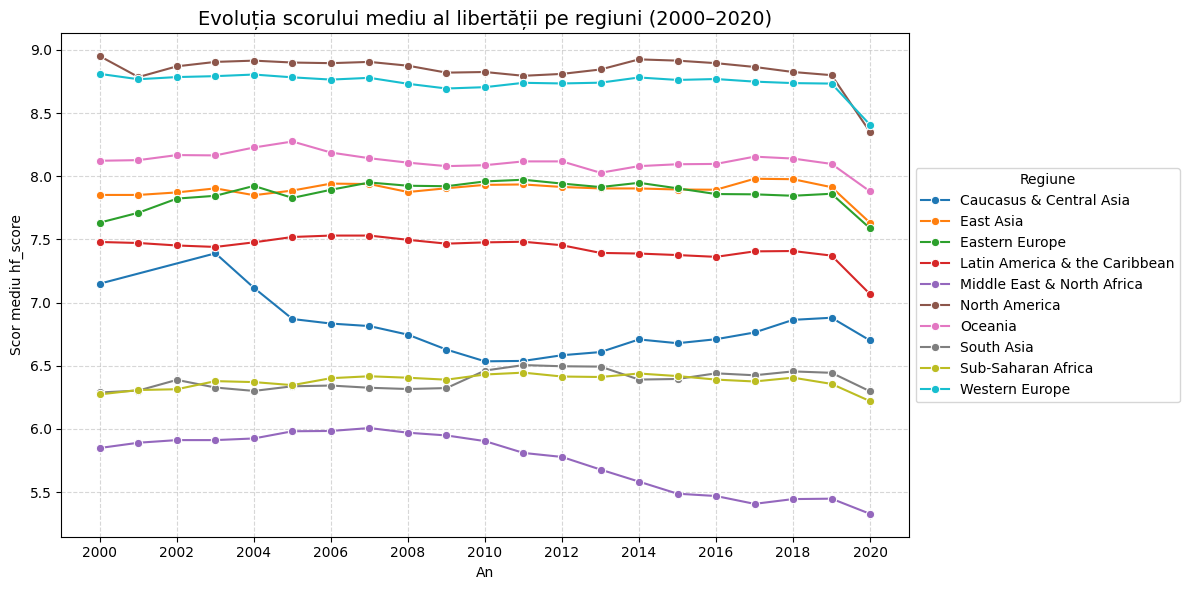

In [64]:
# 4. Vizualizare cu seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_plot,
    x="year",
    y="avg_hf_score",
    hue="region",
    marker="o"
)

plt.title("Evoluția scorului mediu al libertății pe regiuni (2000–2020)", fontsize=14)
plt.xlabel("An")
plt.ylabel("Scor mediu hf_score")
plt.xticks(range(2000, 2021, 2))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Regiune", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### 2.2.4 Relația dintre libertatea personală și libertatea economică

**Obiectiv**: să analizăm relația dintre pf_score (libertate personală) și ef_score (libertate economică), pentru a înțelege dacă există o corelație directă între cele două dimensiuni ale libertății. Ne întrebăm: țările care oferă mai multă libertate personală oferă automat și mai multă libertate economică?

Pentru aceasta, vom:

- folosi un scatter plot colorat în funcție de regiune;

- calcula coeficientul de corelație Pearson pentru a măsura intensitatea și direcția legăturii;

- compara relația folosind toate înregistrările anuale versus scoruri medii pe țară.

In [65]:
# 1. Selectăm scorurile necesare și eliminăm valorile lipsă
df_pair = df_cleaned.select("countries", "region", "year", "pf_score", "ef_score") \
    .dropna(subset=["pf_score", "ef_score"])

In [66]:
# 2. Conversie la Pandas pentru vizualizare
df_pair_pd = df_pair.toPandas()

In [67]:
df_pair_pd

,countries,region,year,pf_score,ef_score
0,Albania,Eastern Europe,2020,7.69,7.64
1,Algeria,Middle East & North Africa,2020,5.13,5.12
2,Angola,Sub-Saharan Africa,2020,6.02,5.91
3,Argentina,Latin America & the Caribbean,2020,8.51,4.87
4,Armenia,Caucasus & Central Asia,2020,8.35,7.84
...,...,...,...,...,...
3078,Uruguay,Latin America & the Caribbean,2000,9.04,7.14
3079,"Venezuela, RB",Latin America & the Caribbean,2000,6.79,5.92
3080,Vietnam,South Asia,2000,5.48,5.58
3081,Zambia,Sub-Saharan Africa,2000,7.03,7.04


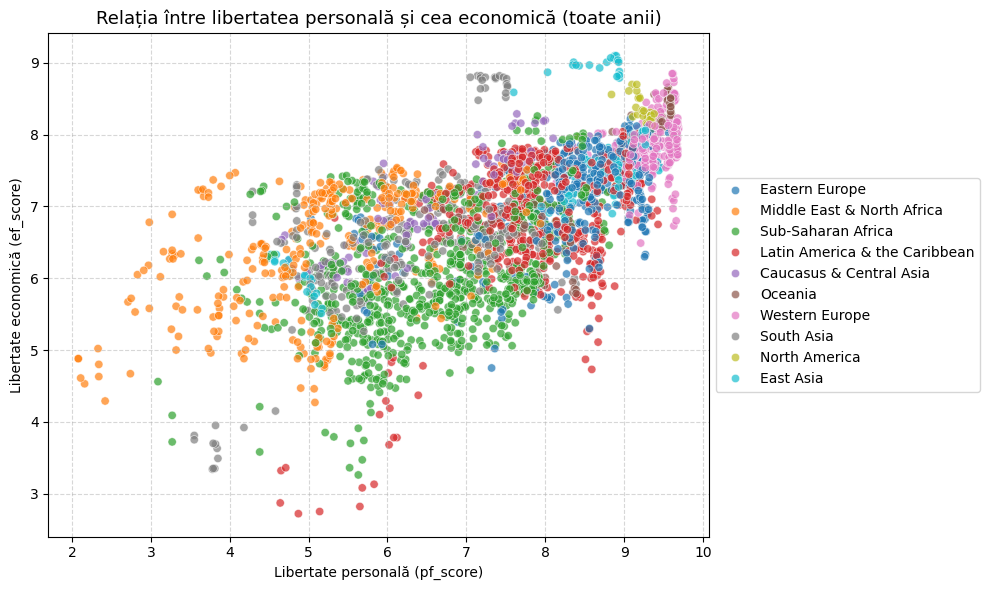

In [68]:
# 3. Vizualizare: scatter plot complet
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pair_pd,
    x="pf_score",
    y="ef_score",
    hue="region",
    alpha=0.7
)

plt.title("Relația între libertatea personală și cea economică (toate anii)", fontsize=13)
plt.xlabel("Libertate personală (pf_score)")
plt.ylabel("Libertate economică (ef_score)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [69]:
# 4. Corelație Pearson + Statistici descriptive
corr_value = df_pair_pd["pf_score"].corr(df_pair_pd["ef_score"])
print(f"Coeficient de corelație Pearson: {corr_value:.4f}")

print("\nStatistici descriptive:")
print(df_pair_pd[["pf_score", "ef_score"]].describe())

Coeficient de corelație Pearson: 0.6600

Statistici descriptive:
          pf_score     ef_score
count  3083.000000  3083.000000
mean      7.373876     6.806610
std       1.577346     0.991279
min       2.080000     2.720000
25%       6.120000     6.130000
50%       7.570000     6.930000
75%       8.700000     7.580000
max       9.690000     9.100000


Observație:

Analiza anterioară a inclus toate înregistrările anuale pentru fiecare țară, ceea ce oferă o imagine detaliată, dar zgomotoasă.  
Pentru a înțelege relația structurală între cele două dimensiuni, vom recomputa scorurile **medii pe țară** pentru perioada 2000–2020 și vom analiza corelația la acest nivel.

In [70]:
# 5. Calcul scoruri medii pe țări și regiuni
df_avg_scores = df_cleaned.groupBy("countries", "region") \
    .agg({"pf_score": "avg", "ef_score": "avg"}) \
    .withColumnRenamed("avg(pf_score)", "avg_pf_score") \
    .withColumnRenamed("avg(ef_score)", "avg_ef_score")

df_avg_scores_pd = df_avg_scores.toPandas()

In [75]:
import pandas as pd

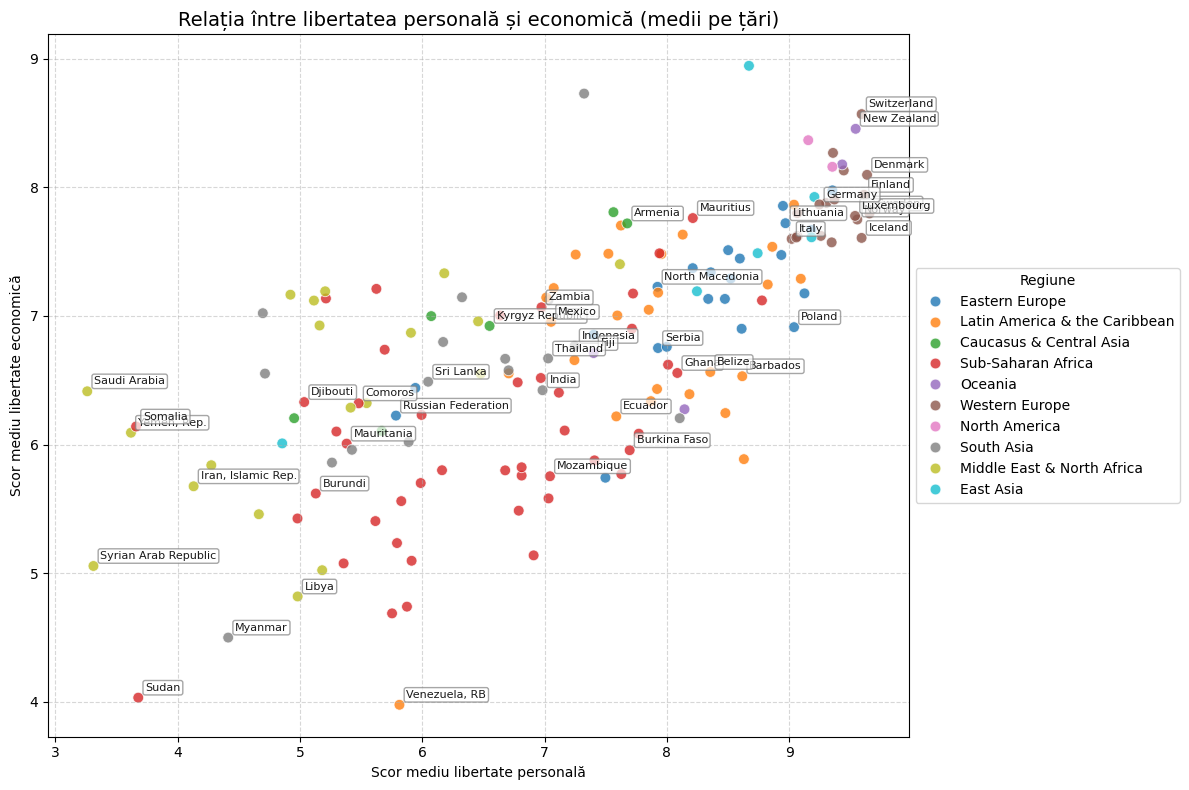

In [81]:
# 6. Scatter plot cu numele unor țări afișate
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_avg_scores_pd,
    x="avg_pf_score",
    y="avg_ef_score",
    hue="region",
    alpha=0.8,
    s=60
)

# Adăugăm etichete pentru țările extreme (wings)
# Identificăm țările cu scoruri foarte mari sau foarte mici
extreme_countries = df_avg_scores_pd[
    (df_avg_scores_pd["avg_pf_score"] >= 9.5) |  # Libertate personală foarte mare
    (df_avg_scores_pd["avg_pf_score"] <= 4.0) |  # Libertate personală foarte mică
    (df_avg_scores_pd["avg_ef_score"] >= 9) |  # Libertate economică foarte mare
    (df_avg_scores_pd["avg_ef_score"] <= 4.5) |  # Libertate economică foarte mică
    (df_avg_scores_pd["avg_pf_score"] + df_avg_scores_pd["avg_ef_score"] >= 18.0) |  # Scoruri totale foarte mari
    (df_avg_scores_pd["avg_pf_score"] + df_avg_scores_pd["avg_ef_score"] <= 10.0)    # Scoruri totale foarte mici
]

# Adăugăm și câteva țări aleatorii pentru context
random_countries = df_avg_scores_pd.sample(30, random_state=42)
countries_to_label = pd.concat([extreme_countries, random_countries]).drop_duplicates()

# Adăugăm etichetele
for idx, row in countries_to_label.iterrows():
    plt.annotate(
        row["countries"],
        (row["avg_pf_score"], row["avg_ef_score"]),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        alpha=0.9,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7, edgecolor="gray")
    )

plt.title("Relația între libertatea personală și economică (medii pe țări)", fontsize=14)
plt.xlabel("Scor mediu libertate personală")
plt.ylabel("Scor mediu libertate economică")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Regiune", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [83]:
# 7. Corelație finală
corr_avg = df_avg_scores_pd["avg_pf_score"].corr(df_avg_scores_pd["avg_ef_score"])
print(f"Coeficient Pearson (medii pe țări): {corr_avg:.4f}")

Coeficient Pearson (medii pe țări): 0.6940


### 2.2.5 Dezechilibrul între libertatea economică și cea personală (`freedom_gap`)

**Obiectiv**: să identificăm țările în care există un dezechilibru semnificativ între libertatea economică (ef_score) și libertatea personală (pf_score), prin introducerea unei noi coloane calculate:
freedom_gap = pf_score - ef_score

- Valori pozitive → țări unde libertatea personală este mai mare decât cea economică
- Valori negative → țări unde libertatea economică este mai mare decât cea personală

Această analiză oferă o perspectivă inedită asupra diferențelor structurale între societăți, scoțând în evidență țări cu politici dezechilibrate sau contradictorii între dimensiunile libertății.

Vom realiza:

- o analiză descriptivă cu Spark și Spark SQL;

- două clasamente: top 10 țări cu cel mai mare exces de libertate personală și top 10 cu exces economic;

- o vizualizare de tip bar chart pentru cele mai dezechilibrate 30 de țări.

In [84]:
from pyspark.sql.functions import round, col
import matplotlib.pyplot as plt
import pandas as pd

In [85]:
# 1. Calculăm diferența: pf_score - ef_score
df_gap = df_cleaned.select("countries", "region", "year", "pf_score", "ef_score") \
    .dropna(subset=["pf_score", "ef_score"]) \
    .withColumn("freedom_gap", round(col("pf_score") - col("ef_score"), 2))

In [86]:
# 2. Calculăm media gap-ului pe țări și regiuni
df_gap_avg = df_gap.groupBy("countries", "region") \
    .agg({"freedom_gap": "avg"}) \
    .withColumnRenamed("avg(freedom_gap)", "avg_freedom_gap") \
    .orderBy(col("avg_freedom_gap").desc())

In [46]:
# 1. Calculam diferenta intre scorurile de libertate personala si economica
df_gap = df_cleaned.select("countries", "region", "year", "pf_score", "ef_score") \
    .dropna(subset=["pf_score", "ef_score"]) \
    .withColumn("freedom_gap", round(col("pf_score") - col("ef_score"), 2))

In [87]:
# 3. Creăm view pentru interogări SQL
df_gap_avg.createOrReplaceTempView("gap_scores")

In [88]:
# 4. Top 10 țări cu libertate personală > economică
print("Top 10 țări: libertate personală mai mare")
spark.sql("""
SELECT countries, region, ROUND(avg_freedom_gap, 2) as gap
FROM gap_scores
WHERE avg_freedom_gap > 0
ORDER BY gap DESC
LIMIT 10
""").show()

Top 10 țări: libertate personală mai mare
+----------------+--------------------+----+
|       countries|              region| gap|
+----------------+--------------------+----+
|       Argentina|Latin America & t...|2.74|
|        Suriname|Latin America & t...|2.23|
|          Poland|      Eastern Europe|2.13|
|        Barbados|Latin America & t...|2.09|
|         Iceland|      Western Europe|1.99|
|        Slovenia|      Eastern Europe|1.95|
|     Timor-Leste|          South Asia| 1.9|
|Papua New Guinea|             Oceania|1.87|
|          Sweden|      Western Europe|1.86|
|          Malawi|  Sub-Saharan Africa|1.86|
+----------------+--------------------+----+



In [89]:
# 5. Top 10 țări cu libertate economică > personală
print("Top 10 țări: libertate economică mai mare")
spark.sql("""
SELECT countries, region, ROUND(avg_freedom_gap, 2) as gap
FROM gap_scores
WHERE avg_freedom_gap < 0
ORDER BY gap ASC
LIMIT 10
""").show()

Top 10 țări: libertate economică mai mare
+--------------------+--------------------+-----+
|           countries|              region|  gap|
+--------------------+--------------------+-----+
|        Saudi Arabia|Middle East & Nor...|-3.15|
|             Somalia|  Sub-Saharan Africa|-2.48|
|         Yemen, Rep.|Middle East & Nor...|-2.47|
|   Brunei Darussalam|          South Asia|-2.32|
|             Bahrain|Middle East & Nor...|-2.24|
|               Qatar|Middle East & Nor...| -2.0|
|United Arab Emirates|Middle East & Nor...|-1.98|
|         Gambia, The|  Sub-Saharan Africa|-1.92|
|             Lao PDR|          South Asia|-1.84|
|                Oman|Middle East & Nor...|-1.76|
+--------------------+--------------------+-----+



In [90]:
# 6. Pregătim vizualizarea cu cele mai dezechilibrate cazuri
df_gap_plot = df_gap_avg.toPandas()

In [91]:
# Selectăm cele mai dezechilibrate 30 de țări (15 pozitive, 15 negative)
top_positive = df_gap_plot.nlargest(15, 'avg_freedom_gap')
top_negative = df_gap_plot.nsmallest(15, 'avg_freedom_gap')
extreme_gaps = pd.concat([top_positive, top_negative]).sort_values("avg_freedom_gap", ascending=False)

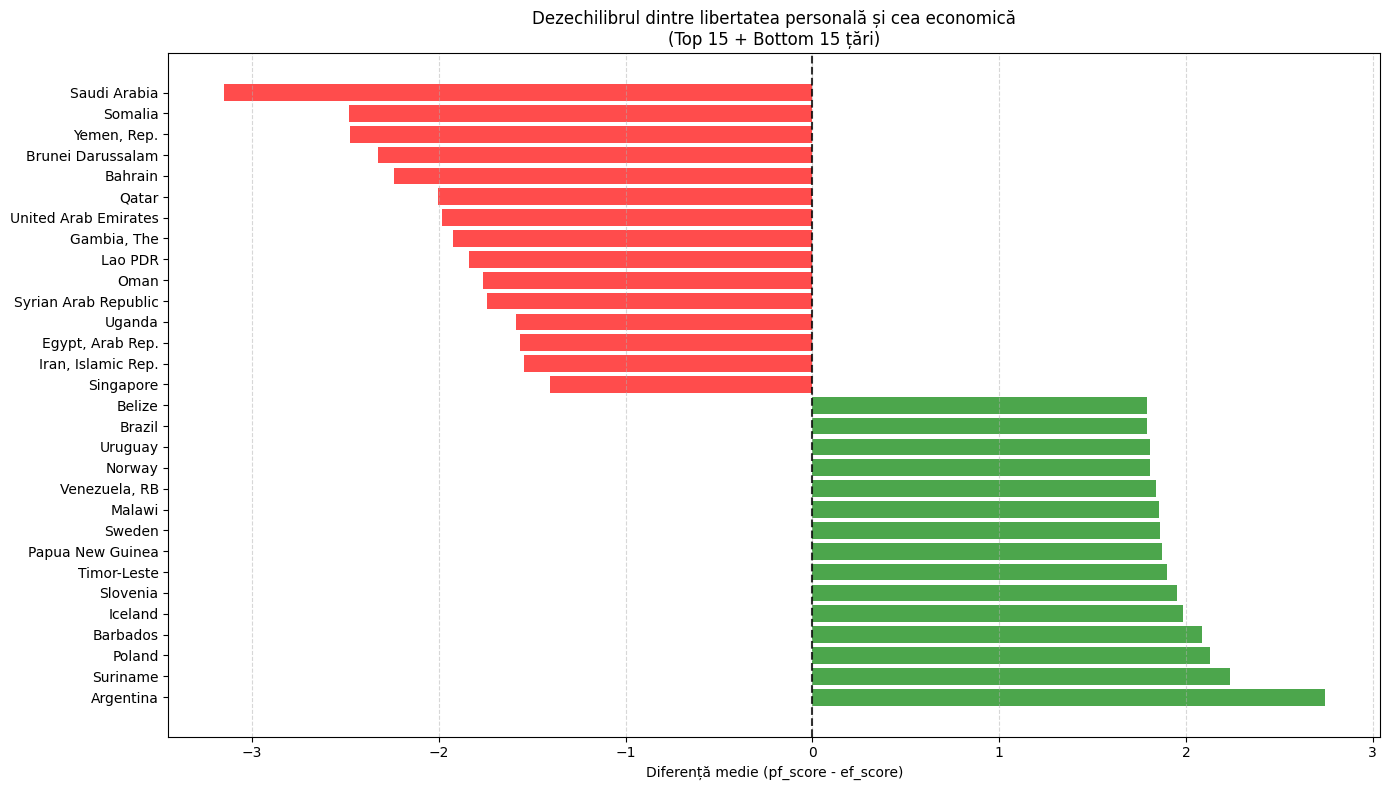

In [92]:
# 7. Bar chart cu colorare în funcție de semn
plt.figure(figsize=(14, 8))
colors = ['green' if x > 0 else 'red' for x in extreme_gaps['avg_freedom_gap']]
plt.barh(range(len(extreme_gaps)), extreme_gaps['avg_freedom_gap'], color=colors, alpha=0.7)
plt.yticks(range(len(extreme_gaps)), extreme_gaps['countries'])
plt.title("Dezechilibrul dintre libertatea personală și cea economică\n(Top 15 + Bottom 15 țări)")
plt.xlabel("Diferență medie (pf_score - ef_score)")
plt.axvline(x=0, color='black', linestyle='--', alpha=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 2.2.6 Țările cu cel mai scăzut nivel al libertății de exprimare

### Descriere și obiectiv

În această analiză dorim să identificăm țările cu cel mai scăzut nivel al libertății de exprimare în perioada 2000–2020, folosind indicatorul pf_expression_direct.

Acest scor reflectă nivelul de represiune exercitat de autorități asupra jurnaliștilor, activiștilor și cetățenilor, incluzând:

- arestări politice;

- amenințări și intimidări sistematice;

- acte de violență împotriva libertății de opinie.

Prin calculul mediei pe 20 de ani, obținem o imagine de ansamblu stabilă asupra climatului represiv din diferite țări.

Vor fi prezentate:

- Top 10 țări cu cel mai scăzut scor mediu la pf_expression_direct;

- o vizualizare de tip bar chart, cu segmentare pe regiuni.

In [93]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
# 1. Selectăm coloanele relevante și eliminăm valorile lipsă
df_expr = df_cleaned.select("countries", "year", "region", "pf_expression_direct") \
    .dropna(subset=["pf_expression_direct"])

In [96]:
# 2. Creăm view temporar pentru interogare SQL
df_expr.createOrReplaceTempView("expr_view")

In [97]:
# 3. Calculăm media scorului între 2000 și 2020 pentru fiecare țară
expr_avg_df = spark.sql("""
    SELECT countries, region, ROUND(AVG(pf_expression_direct), 2) AS avg_expression_score
    FROM expr_view
    WHERE year BETWEEN 2000 AND 2020
    GROUP BY countries, region
    ORDER BY avg_expression_score ASC
    LIMIT 10
""")

expr_avg_df.show(truncate=False)

+--------------------+--------------------------+--------------------+
|countries           |region                    |avg_expression_score|
+--------------------+--------------------------+--------------------+
|Somalia             |Sub-Saharan Africa        |1.67                |
|Israel              |Middle East & North Africa|2.32                |
|Gambia, The         |Sub-Saharan Africa        |3.18                |
|Azerbaijan          |Caucasus & Central Asia   |3.3                 |
|Syrian Arab Republic|Middle East & North Africa|4.19                |
|Libya               |Middle East & North Africa|4.27                |
|Iraq                |Middle East & North Africa|4.36                |
|Yemen, Rep.         |Middle East & North Africa|4.87                |
|Myanmar             |South Asia                |4.93                |
|Turkey              |Middle East & North Africa|4.97                |
+--------------------+--------------------------+--------------------+



In [98]:
# 4. Conversie pentru vizualizare
expr_avg_pd = expr_avg_df.toPandas()

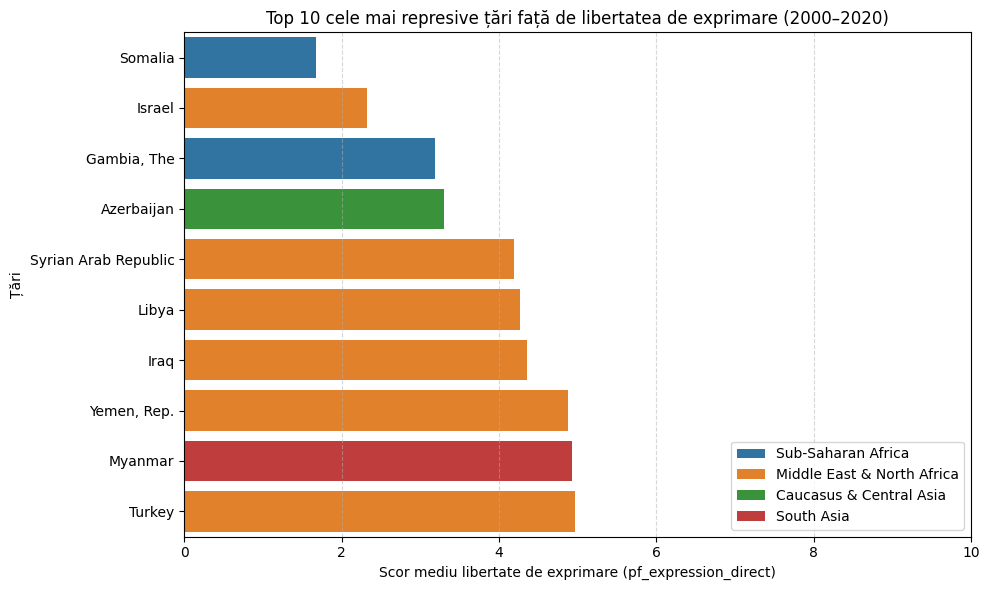

In [99]:
# 5. Plot Top 10 cele mai represive țări
plt.figure(figsize=(10, 6))
sns.barplot(data=expr_avg_pd, y="countries", x="avg_expression_score", hue="region", dodge=False)
plt.title("Top 10 cele mai represive țări față de libertatea de exprimare (2000–2020)")
plt.xlabel("Scor mediu libertate de exprimare (pf_expression_direct)")
plt.ylabel("Țări")
plt.xlim(0, 10)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 2.2.7 Clasificarea țărilor în categorii de libertate: High / Medium / Low

Descriere și obiectiv: Scorul compozit de libertate (hf_score) este un indicator complex, dar poate deveni mai intuitiv dacă îl clasificăm în categorii semnificative. Astfel, vom eticheta fiecare observație în una dintre cele trei clase:

- **🔵 High Freedom**: scor ≥ 8.5
- **🟡 Medium Freedom**: între 6.5 și 8.5  
- **🔴 Low Freedom**: scor < 6.5

Această etichetare ne va permite:

- să analizăm distribuția libertății în funcție de regiune;

- să observăm evoluția categoriilor în timp (2000–2020);

- să construim o vizualizare stacked care evidențiază dinamica libertății la nivel global.

Vom folosi atât Spark SQL, cât și PySpark DataFrames, iar pentru vizualizare – Pandas + Matplotlib.

In [100]:
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

In [101]:
# 1. Clasificare scoruri in categorii
df_categorized = df_cleaned.withColumn(
    "freedom_category",
    when(col("hf_score") >= 8.5, "High")
    .when((col("hf_score") >= 6.5) & (col("hf_score") < 8.5), "Medium")
    .otherwise("Low")
)

In [102]:
# 2. Creăm view temporar pentru SQL
df_categorized.createOrReplaceTempView("freedom_categorized")

In [103]:
# 3. Distribuție per regiune
spark.sql("""
    SELECT region, freedom_category, COUNT(*) as count
    FROM freedom_categorized
    GROUP BY region, freedom_category
    ORDER BY region, freedom_category
""").show(truncate=False)

+-----------------------------+----------------+-----+
|region                       |freedom_category|count|
+-----------------------------+----------------+-----+
|Caucasus & Central Asia      |Low             |40   |
|Caucasus & Central Asia      |Medium          |56   |
|East Asia                    |High            |48   |
|East Asia                    |Low             |21   |
|East Asia                    |Medium          |53   |
|Eastern Europe               |High            |63   |
|Eastern Europe               |Low             |29   |
|Eastern Europe               |Medium          |331  |
|Latin America & the Caribbean|High            |19   |
|Latin America & the Caribbean|Low             |29   |
|Latin America & the Caribbean|Medium          |488  |
|Middle East & North Africa   |Low             |259  |
|Middle East & North Africa   |Medium          |71   |
|North America                |High            |40   |
|North America                |Medium          |2    |
|Oceania  

In [104]:
# 4. Distribuție anuală
df_yearly_dist = spark.sql("""
    SELECT year, freedom_category, COUNT(*) as count
    FROM freedom_categorized
    GROUP BY year, freedom_category
    ORDER BY year ASC, freedom_category
""")

In [105]:
# 5. Convertim la Pandas + pivot
df_yearly_dist_pd = df_yearly_dist.toPandas()
df_pivot = df_yearly_dist_pd.pivot(index="year", columns="freedom_category", values="count").fillna(0)

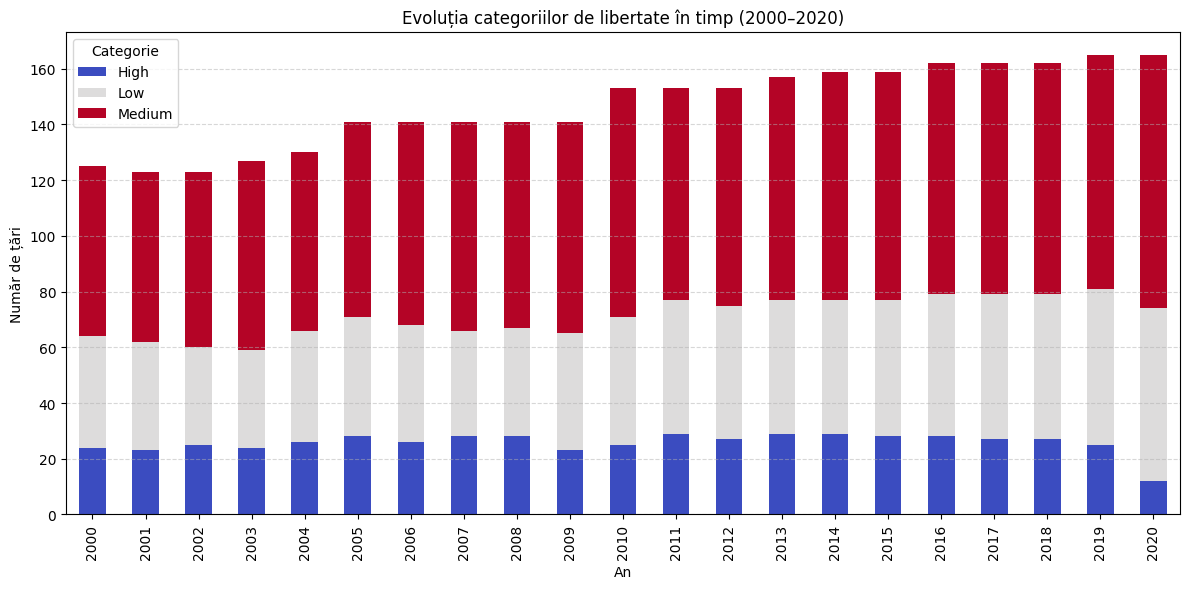

In [106]:
# 6. Plot stacked bars
df_pivot.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(12,6))
plt.title("Evoluția categoriilor de libertate în timp (2000–2020)")
plt.xlabel("An")
plt.ylabel("Număr de țări")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Categorie")
plt.tight_layout()
plt.show()

In [107]:
columns_list = df_cleaned.columns
print(f"Coloane din DataFrame-ul curățat ({len(columns_list)} total):")
print(", ".join(columns_list))

Coloane din DataFrame-ul curățat (136 total):
year, countries, region, hf_score, hf_rank, hf_quartile, pf_rol_vdem, pf_rol, pf_ss_homicide, pf_ss_homicide_data, pf_ss_disappearances_disap, pf_ss_disappearances_violent, pf_ss_disappearances_violent_data, pf_ss_disappearances_organized, pf_ss_disappearances_fatalities, pf_ss_disappearances_fatalities_data, pf_ss_disappearances_injuries, pf_ss_disappearances_injuries_data, pf_ss_disappearances_torture, pf_ss_killings, pf_ss_disappearances, pf_ss, pf_movement_vdem_foreign, pf_movement_vdem_men, pf_movement_vdem_women, pf_movement_vdem, pf_movement_cld, pf_movement, pf_religion_freedom_vdem, pf_religion_freedom_cld, pf_religion_freedom, pf_religion_suppression, pf_religion, pf_assembly_entry, pf_assembly_freedom_house, pf_assembly_freedom_bti, pf_assembly_freedom_cld, pf_assembly_freedom, pf_assembly_parties_barriers, pf_assembly_parties_bans, pf_assembly_parties_auton, pf_assembly_parties, pf_assembly_civil, pf_assembly, pf_expression_dire

# 3. Aplicarea metodelor de Machine Learning cu Spark MLlib

## 3.1 Predicția scorului de libertate umană (`hf_score`) – Regressie

### Obiectiv

În această secțiune vom construi un model de regresie care va avea ca scop **prezicerea scorului total de libertate umană (`hf_score`)** pentru o țară într-un anumit an, utilizând variabile socio-politice și economice disponibile în setul de date.

Ne propunem să obținem:
- un model robust și interpretabil;
- o înțelegere a **factorilor determinanți** asupra `hf_score`;
- o evaluare a performanței modelului pe un set de testare;
- o analiză a **importanței variabilelor** pentru transparență și insight.

Vom folosi **Spark MLlib**, urmând o abordare modulară și reproductibilă, folosind un **pipeline complet**.

---

### Metodologie

1. Alegerea coloanelor explicative (excludem: `hf_score`, `hf_rank`, `countries`, `region`, `year`)
2. Eliminarea observațiilor incomplete
3. Indexarea variabilei categorice `region`
4. Combinarea feature-urilor într-un vector (VectorAssembler)
5. Împărțirea datelor în seturi de antrenare și test (80/20)
6. Antrenarea modelului `RandomForestRegressor`
7. Evaluarea performanței modelului folosind:
   - **MAE** (Mean Absolute Error)
   - **RMSE** (Root Mean Squared Error)
   - **R²** (coeficientul de determinare)
8. Extracția și interpretarea importanței variabilelor

In [128]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import mean

In [129]:
# 1. Selectăm coloanele explicative (numerice continue)
excluded_cols = ["countries", "hf_score", "hf_rank", "hf_quartile", "region", "year"]
all_features = [
    c for c in df_cleaned.columns
    if c not in excluded_cols and df_cleaned.schema[c].dataType.simpleString() == "double"
]

In [130]:
# 2. Completăm valorile lipsă cu media fiecărei coloane numerice
fill_dict = {}
for feature in all_features:
    mean_val = df_cleaned.select(mean(col(feature))).first()[0]
    fill_dict[feature] = float(mean_val)

# Dacă vrem, putem include și completare pentru hf_score (opțional, doar pentru predicție)
mean_hf_score = df_cleaned.select(mean("hf_score")).first()[0]
fill_dict["hf_score"] = float(mean_hf_score)

# Completăm NaN-urile
df_model = df_cleaned.fillna(fill_dict)

# Dacă există și categorii lipsă în "region", completăm și acolo
df_model = df_model.fillna({"region": "Unknown"})

print("Număr total de observații după completare:", df_model.count())

Număr total de observații după completare: 3083


In [131]:
# 3. Indexare coloană categorică 'region'
region_indexer = StringIndexer(inputCol="region", outputCol="region_index", handleInvalid="keep")

In [132]:
# 4. Combinare feature-uri într-un vector
assembler = VectorAssembler(inputCols=all_features + ["region_index"], outputCol="features")

In [133]:
# 5. Definirea modelului
rf = RandomForestRegressor(featuresCol="features", labelCol="hf_score", numTrees=100, maxDepth=10, seed=42)

In [134]:
# 6. Pipeline complet
pipeline = Pipeline(stages=[region_indexer, assembler, rf])

In [135]:
# 7. Împărțirea datelor
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=42)
print(f"Train: {train_data.count()} rânduri | Test: {test_data.count()} rânduri")

Train: 2511 rânduri | Test: 572 rânduri


In [136]:
# 8. Antrenarea modelului
model = pipeline.fit(train_data)

In [139]:
# 9. Predictii pe test
predictions = model.transform(test_data)

In [140]:
# 10. Evaluare performanță
mae = RegressionEvaluator(labelCol="hf_score", predictionCol="prediction", metricName="mae")
rmse = RegressionEvaluator(labelCol="hf_score", predictionCol="prediction", metricName="rmse")
r2 = RegressionEvaluator(labelCol="hf_score", predictionCol="prediction", metricName="r2")

print("\nEvaluare model Random Forest Regressor:")
print(f"MAE:  {mae.evaluate(predictions):.4f}")
print(f"RMSE: {rmse.evaluate(predictions):.4f}")
print(f"R²:   {r2.evaluate(predictions):.4f}")


Evaluare model Random Forest Regressor:
MAE:  0.0480
RMSE: 0.0733
R²:   0.9965


In [141]:
# 11. Importanța variabilelor
rf_model = model.stages[-1]  # extragem modelul Random Forest
importances = rf_model.featureImportances.toArray()
features_final = all_features + ["region_index"]

importances_df = pd.DataFrame({
    "feature": features_final,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 10 cele mai importante variabile pentru predicția hf_score:")
print(importances_df.head(10))


Top 10 cele mai importante variabile pentru predicția hf_score:
                       feature  importance
58                    pf_score    0.322954
59                     pf_rank    0.203716
31         pf_assembly_freedom    0.093484
0                  pf_rol_vdem    0.091060
37                 pf_assembly    0.060781
50               pf_expression    0.029668
123                   ef_score    0.029553
28   pf_assembly_freedom_house    0.018893
80                    ef_legal    0.016846
124                    ef_rank    0.016815


In [142]:
# 12. Convertim la Pandas pentru analiză de erori
predictions_pd = predictions.select("countries", "region", "hf_score", "prediction", "year").toPandas()
predictions_pd["residual"] = predictions_pd["hf_score"] - predictions_pd["prediction"]

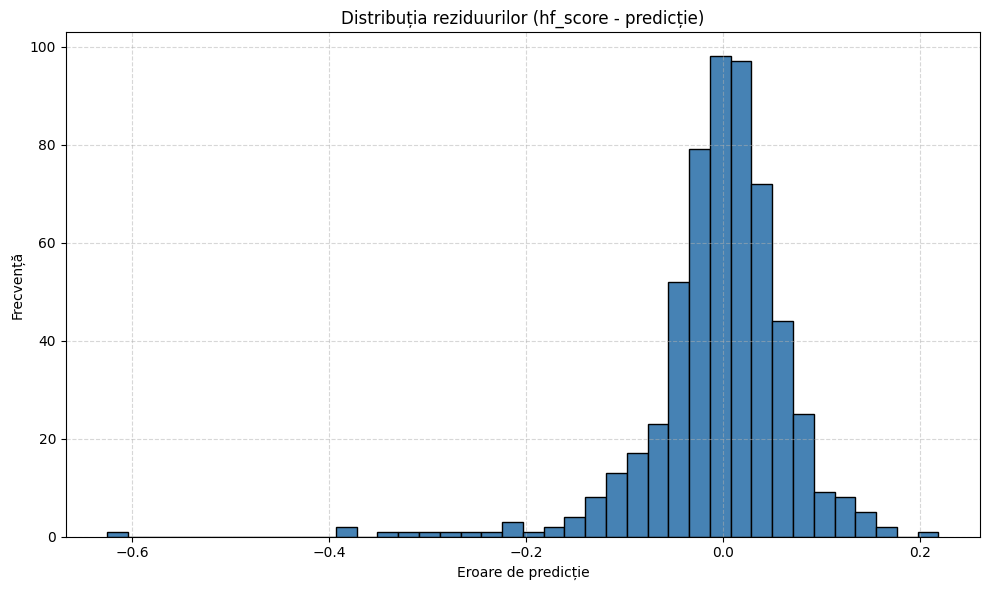

In [143]:
# 13. Vizualizare: Erori de predicție (opțional)
plt.figure(figsize=(10, 6))
plt.hist(predictions_pd["residual"], bins=40, color="steelblue", edgecolor="black")
plt.title("Distribuția reziduurilor (hf_score - predicție)")
plt.xlabel("Eroare de predicție")
plt.ylabel("Frecvență")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

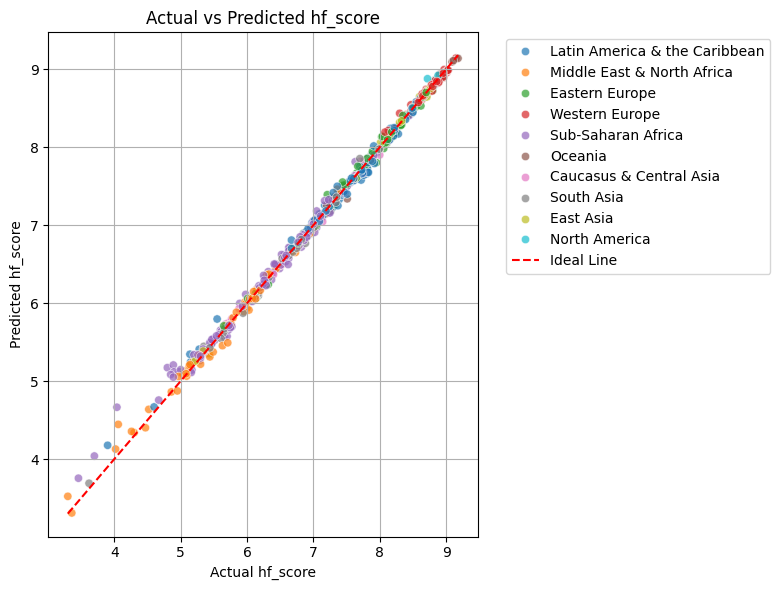

In [144]:
# 1. Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(data=predictions_pd, x="hf_score", y="prediction", hue="region", alpha=0.7)
plt.plot([predictions_pd["hf_score"].min(), predictions_pd["hf_score"].max()],
         [predictions_pd["hf_score"].min(), predictions_pd["hf_score"].max()],
         'r--', label="Ideal Line")
plt.xlabel("Actual hf_score")
plt.ylabel("Predicted hf_score")
plt.title("Actual vs Predicted hf_score")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

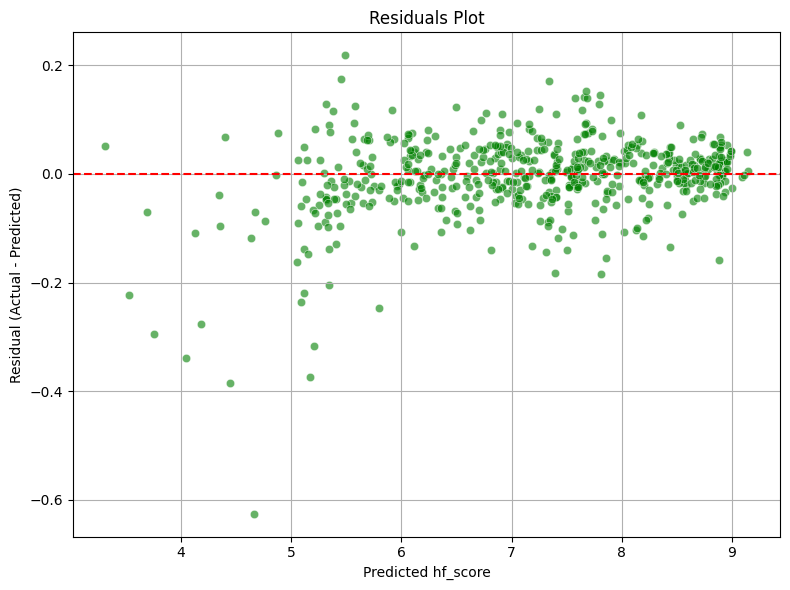

In [145]:
# 2. Residuals Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=predictions_pd, x="prediction", y="residual", color='green', alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted hf_score")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

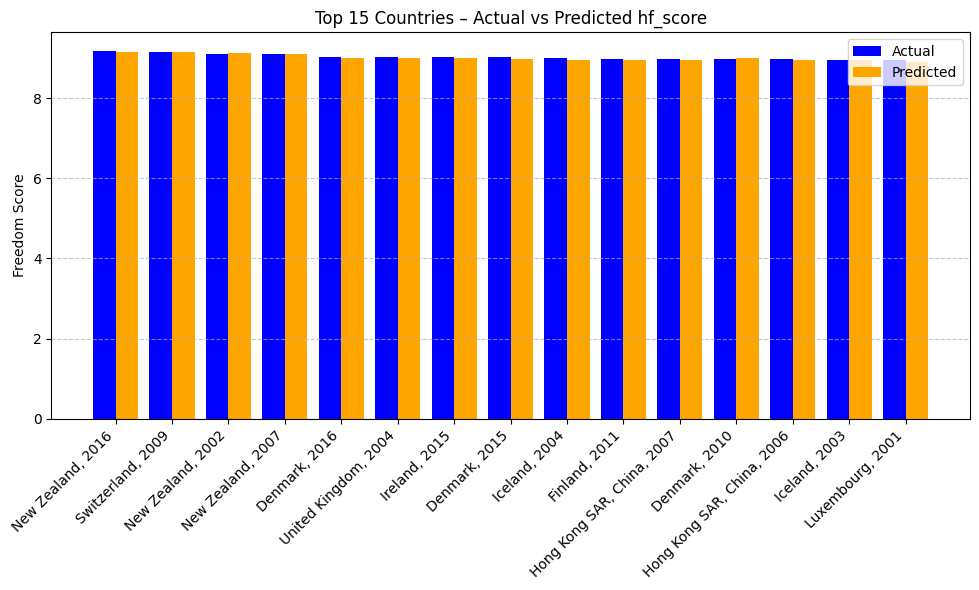

In [146]:
# 3. Bar Plot: Top 15 countries by actual hf_score
top_15 = predictions_pd.sort_values(by="hf_score", ascending=False).head(15)
plt.figure(figsize=(10, 6))
x = range(len(top_15))
plt.bar([i - 0.2 for i in x], top_15["hf_score"], width=0.4, label="Actual", color='blue')
plt.bar([i + 0.2 for i in x], top_15["prediction"], width=0.4, label="Predicted", color='orange')
plt.xticks(x, top_15["countries"] + ", " + top_15["year"].astype(str), rotation=45, ha="right")
plt.ylabel("Freedom Score")
plt.title("Top 15 Countries – Actual vs Predicted hf_score")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

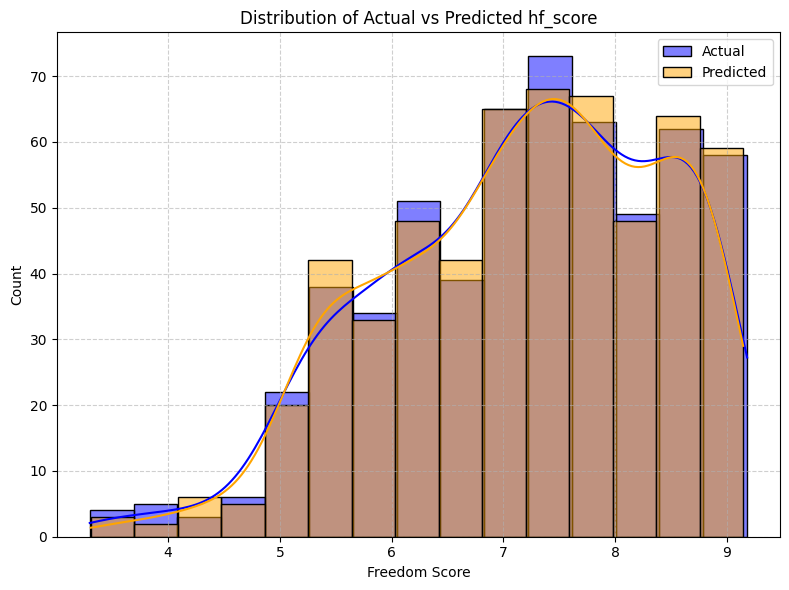

In [147]:
# 4. Histogram comparison
plt.figure(figsize=(8, 6))
sns.histplot(predictions_pd["hf_score"], color="blue", label="Actual", kde=True, bins=15)
sns.histplot(predictions_pd["prediction"], color="orange", label="Predicted", kde=True, bins=15)
plt.xlabel("Freedom Score")
plt.title("Distribution of Actual vs Predicted hf_score")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

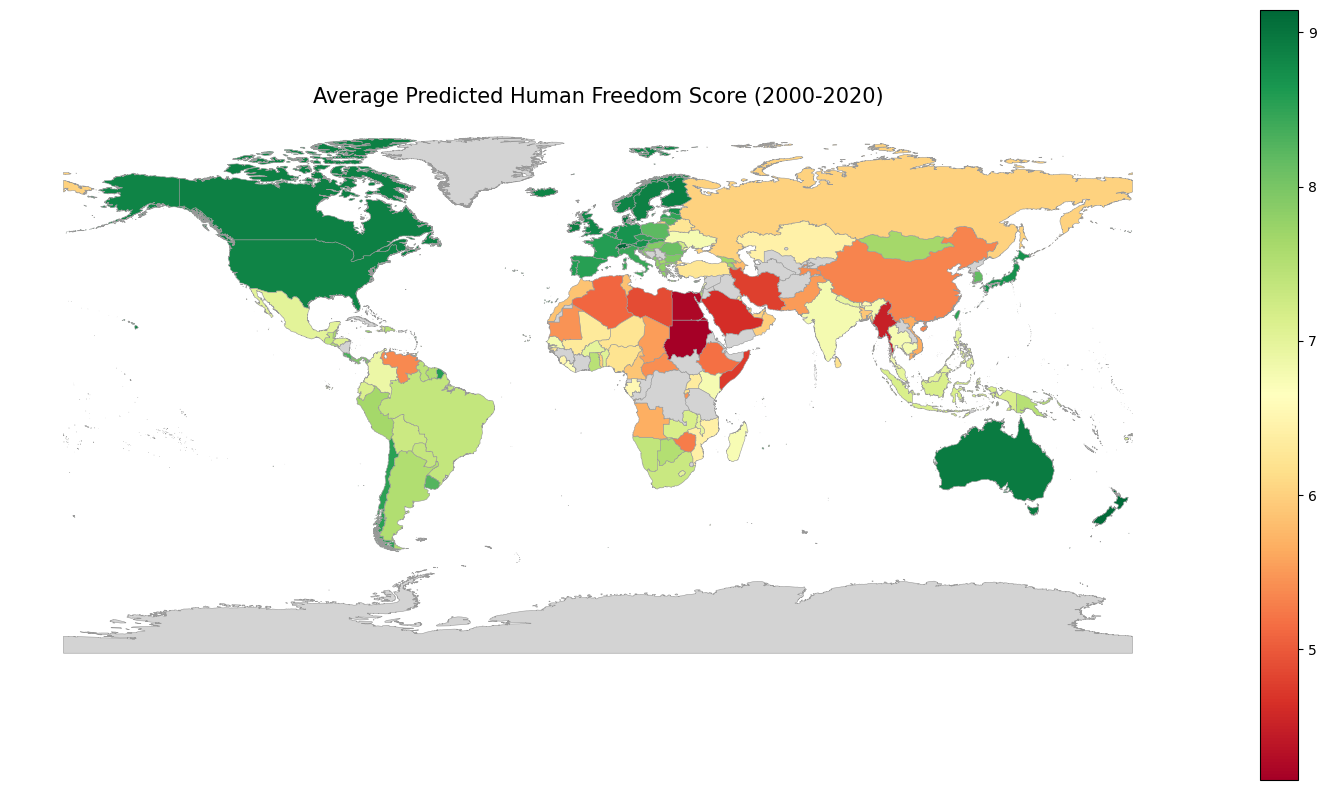

In [148]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# 1. Media scorului prezis pe fiecare țară
avg_pred = (
    predictions_pd
    .groupby("countries", as_index=False)["prediction"]
    .mean()
    .rename(columns={"countries": "country", "prediction": "avg_pred"})
)

# 2. Corecții de nume
name_fix = {
    "United States": "United States of America",
    "Russian Federation": "Russia",
    "Korea, Rep.": "South Korea",
    "Czech Republic": "Czechia",
    "Slovak Republic": "Slovakia",
    "Egypt, Arab Rep.": "Egypt",
    "Venezuela, RB": "Venezuela",
    "Iran, Islamic Rep.": "Iran",
    "Gambia, The": "Gambia",
}
avg_pred["country"] = avg_pred["country"].replace(name_fix)

# 3. Încercăm să încărcăm Natural Earth; dacă nu există -> fallback GeoJSON
try:
    world_path = gpd.datasets.get_path("naturalearth_lowres")          # funcționează pe GeoPandas < 1.0
    world = gpd.read_file(world_path)
    country_col = "name"
except (AttributeError, KeyError):
    url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
    world = gpd.read_file(url)
    # în acest GeoJSON numele țării e stocat în 'ADMIN'
    world = world.rename(columns={"ADMIN": "name"})
    country_col = "name"

# 4. Merge
world_merge = world.merge(avg_pred, left_on=country_col, right_on="country", how="left")

# 5-A. Hartă statică
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
world_merge.plot(
    column="avg_pred",
    cmap="RdYlGn",
    linewidth=0.4,
    ax=ax,
    edgecolor="0.6",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data",
        "edgecolor": "0.6",
    },
)
ax.set_title("Average Predicted Human Freedom Score (2000-2020)", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()

# 5-B. Hartă interactivă
fig = px.choropleth(
    avg_pred,
    locations="country",
    locationmode="country names",
    color="avg_pred",
    color_continuous_scale="RdYlGn",
    range_color=[4, 9],
    title="Average Predicted Human Freedom Score (2000-2020)",
    labels={"avg_pred": "Pred. HF Score"},
    hover_name="country",
)
fig.update_layout(height=600, margin=dict(r=0, t=50, l=0, b=0))
fig.show()


## 3.2 Clasificarea nivelului de libertate (`freedom_category`) – Clasificare

### Obiectiv general

Construirea unui model de clasificare care încadrează fiecare observație într-una dintre cele trei **categorii de libertate**:

* 🔵 **High Freedom** (`hf_score ≥ 8.5`)
* 🟡 **Medium Freedom** (`6.5 ≤ hf_score < 8.5`)
* 🔴 **Low Freedom** (`hf_score < 6.5`)

Scopul este să anticipăm nivelul de libertate al unei țări, bazându-ne exclusiv pe variabile socio-politice și economice, fără a folosi direct scorul numeric.

### Model ales: `Logistic Regression` (multinomială)

* Oferă o interpretare transparentă a influenței fiecărui factor.
* Potrivit pentru probleme de clasificare multi-clasă.
* Poate fi echilibrat prin ponderi automate, pentru a gestiona clasele dezechilibrate.

### Etape metodologice

1. **Etichetare**: creăm coloana `freedom_category` pe baza lui `hf_score`;
2. **Excluderi**: eliminăm coloanele ce pot influența artificial modelul (`hf_score`, `pf_score`, etc.);
3. **Preprocesare**: indexăm regiunea, vectorizăm feature-urile numerice;
4. **Ponderare**: atribuim ponderi inverse pentru clasele dezechilibrate;
5. **Antrenare model**: Logistic Regression multinomială cu Grid Search și Cross-Validation (F1 ca scor de optimizare);
6. **Evaluare**: folosim accuracy, F1, precision, recall;
7. **Salvare și încărcare model final** pentru folosire ulterioară.

In [149]:
from pyspark.sql.functions import when, col, count, lit
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import when

In [150]:
# 1. Etichetare în High / Medium / Low
df_labeled = (
    df_cleaned
    .withColumn(
        "freedom_category",
        when(col("hf_score") >= 8.5, "High")
        .when((col("hf_score") >= 6.5) & (col("hf_score") < 8.5), "Medium")
        .otherwise("Low")
    )
)

In [151]:
# 2. Selectăm coloanele relevante (excludem scorurile directe și altele redundant-informative)
excluded_cols = [
    "countries", "hf_score", "hf_rank", "hf_quartile",
    "pf_score", "pf_rank", "ef_score", "ef_rank",
    "freedom_category"
]
all_features = [
    c for c in df_labeled.columns
    if c not in excluded_cols and df_labeled.schema[c].dataType.simpleString() in ("double", "int")
]

In [152]:
# 3. Eliminăm observațiile incomplete
df_nonnull = df_labeled.dropna(subset=all_features + ["freedom_category", "region"])

In [153]:
# 4. Indexăm eticheta (categorii de libertate)
cat_indexer = StringIndexer(inputCol="freedom_category", outputCol="label", handleInvalid="skip")
df_indexed = cat_indexer.fit(df_nonnull).transform(df_nonnull)

In [154]:
# 5. Calculăm ponderi inverse pentru clase dezechilibrate
cnts = df_indexed.groupBy("label").agg(count("*").alias("cnt")).orderBy("label").toPandas()
total = cnts["cnt"].sum()
n_classes = cnts.shape[0]
weights_d = {r["label"]: (total / (n_classes * r["cnt"])) for _, r in cnts.iterrows()}

df_weighted = (
    df_indexed
    .withColumn(
        "sample_weight",
        when(col("label") == 0.0, lit(weights_d[0.0]))
        .when(col("label") == 1.0, lit(weights_d[1.0]))
        .otherwise(lit(weights_d[2.0]))
    )
)

In [155]:
# 6. Pipeline complet
region_indexer = StringIndexer(inputCol="region", outputCol="region_index", handleInvalid="keep")
assembler = VectorAssembler(inputCols=all_features + ["region_index"], outputCol="features")
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    weightCol="sample_weight",
    family="multinomial",
    maxIter=200,
    tol=1e-6
)
pipeline = Pipeline(stages=[region_indexer, assembler, lr])

In [156]:
# 7. Împărțire în train/test
train_data, test_data = df_weighted.randomSplit([0.8, 0.2], seed=42)

In [157]:
# 8. ParamGrid + CrossValidation
param_grid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.001, 0.01, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.3, 0.7])
    .build()
)
eval_f1 = MulticlassClassificationEvaluator(metricName="f1", labelCol="label", predictionCol="prediction")
cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=eval_f1,
    numFolds=3,
    parallelism=2,
    seed=42
)

In [158]:
# 9. Antrenare și predicție
cv_model = cv.fit(train_data)
best_model = cv_model.bestModel
predictions = best_model.transform(test_data)

In [162]:
# 10. Evaluare model fără salvare locală
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluare pe setul de test
evaluator_acc = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="label", predictionCol="prediction")
evaluator_f1 = MulticlassClassificationEvaluator(metricName="f1", labelCol="label", predictionCol="prediction")
evaluator_precision = MulticlassClassificationEvaluator(metricName="weightedPrecision", labelCol="label", predictionCol="prediction")
evaluator_recall = MulticlassClassificationEvaluator(metricName="weightedRecall", labelCol="label", predictionCol="prediction")

accuracy = evaluator_acc.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)

print("Evaluare model Logistic Regression:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

# Test rapid pe câteva predicții
predictions.select("countries", "region", "freedom_category", "prediction").show(10)

Evaluare model Logistic Regression:
Accuracy:  0.9643
F1 Score:  0.9645
Precision: 0.9660
Recall:    0.9643
+--------------------+--------------------+----------------+----------+
|           countries|              region|freedom_category|prediction|
+--------------------+--------------------+----------------+----------+
|          Azerbaijan|Caucasus & Centra...|             Low|       1.0|
|Bosnia and Herzeg...|      Eastern Europe|          Medium|       0.0|
|              Brazil|Latin America & t...|          Medium|       0.0|
|            Colombia|Latin America & t...|          Medium|       0.0|
|         El Salvador|Latin America & t...|          Medium|       0.0|
|            Honduras|Latin America & t...|          Medium|       0.0|
|         Korea, Rep.|           East Asia|          Medium|       0.0|
|            Malaysia|          South Asia|             Low|       1.0|
|              Poland|      Eastern Europe|          Medium|       0.0|
|             Romania|      


Confusion matrix counts:
 prediction  0.0  1.0  2.0
label                    
0.0          96    5    0
1.0           1   57    0
2.0           0    0    9


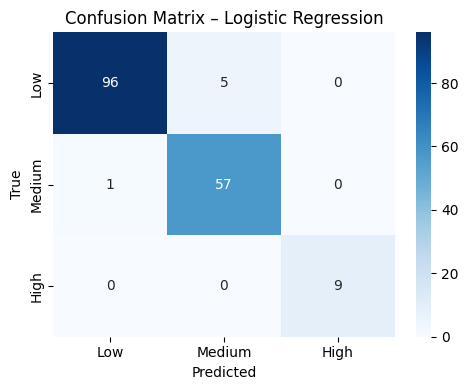

In [165]:
# 11. Confusion Matrix (pretty print + heatmap)
pred_pd = predictions.select("label", "prediction").toPandas()
cm = pd.crosstab(pred_pd["label"], pred_pd["prediction"])
print("\nConfusion matrix counts:\n", cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low","Medium","High"],
            yticklabels=["Low","Medium","High"])
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

C:\Users\stoic\AppData\Local\Temp\ipykernel_10748\292017990.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




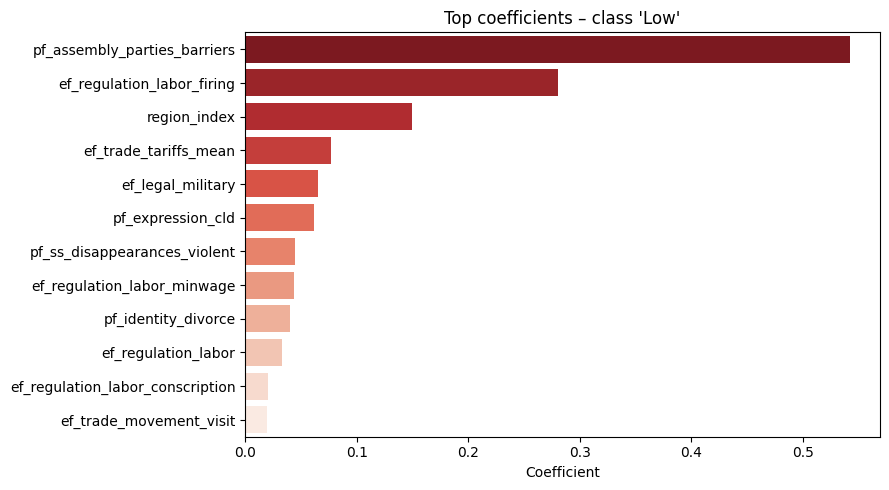

C:\Users\stoic\AppData\Local\Temp\ipykernel_10748\292017990.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




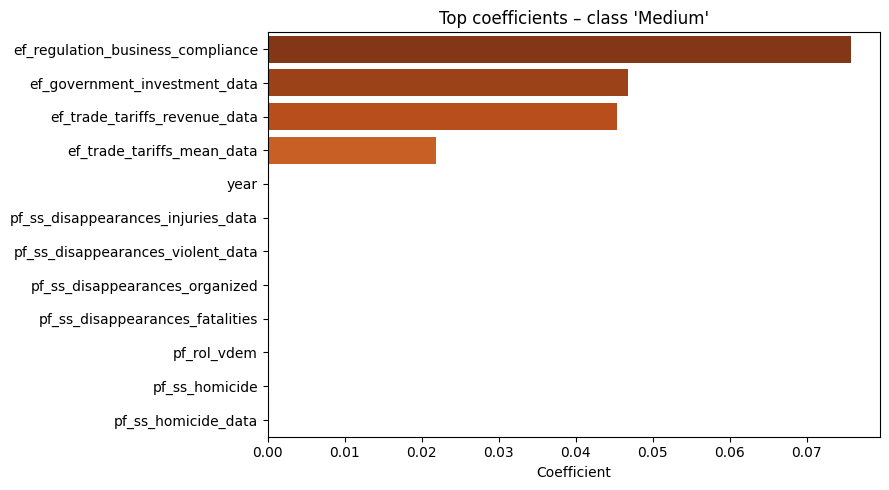

C:\Users\stoic\AppData\Local\Temp\ipykernel_10748\292017990.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




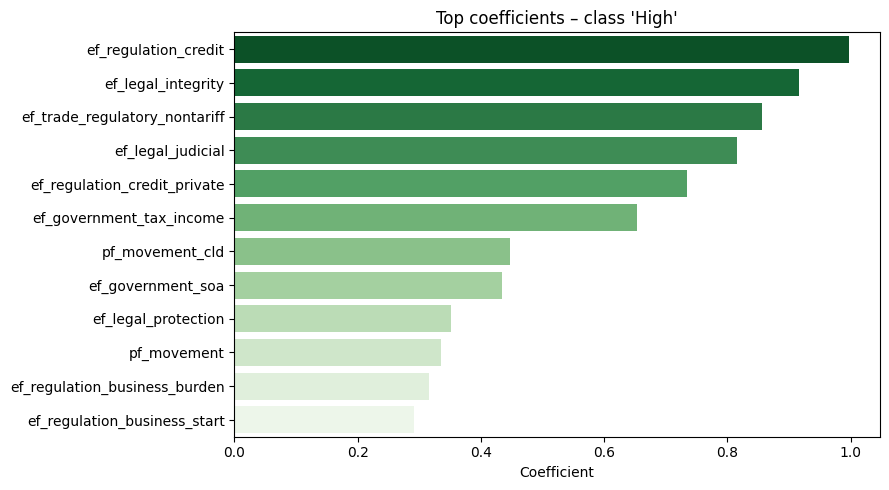

In [166]:
# 12. Top coeficienţi (barplot)  – primele 12 feature-uri / clasă
lr_best = best_model.stages[-1]
coef_mat = lr_best.coefficientMatrix.toArray()
feat_all = all_features + ["region_index"]
labels_order = lr_best.summary.labels   # [0.0,1.0,2.0]

palettes = {0:'Reds_r', 1:'Oranges_r', 2:'Greens_r'}
names    = {0:'Low',    1:'Medium',    2:'High'}

for i, lab in enumerate(labels_order):
    top_df = (
        pd.DataFrame({"feature": feat_all, "coef": coef_mat[i]})
          .sort_values("coef", ascending=False)
          .head(12)
    )
    plt.figure(figsize=(9,5))
    sns.barplot(y="feature", x="coef", data=top_df, palette=palettes[i])
    plt.title(f"Top coefficients – class '{names[int(lab)]}'")
    plt.xlabel("Coefficient"); plt.ylabel("")
    plt.tight_layout(); plt.show()

C:\Users\stoic\AppData\Local\Temp\ipykernel_10748\3234254793.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\stoic\AppData\Local\Temp\ipykernel_10748\3234254793.py:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




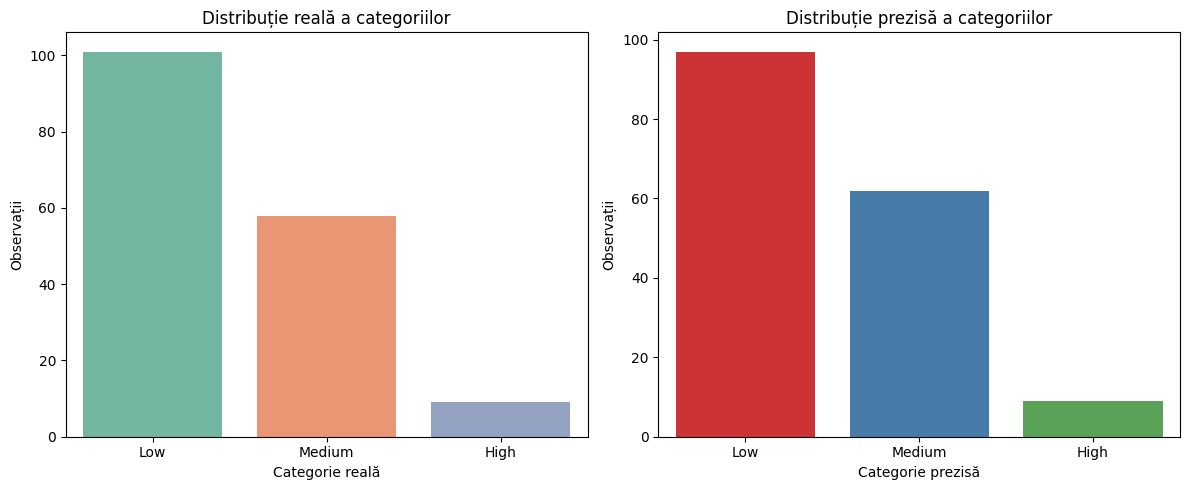

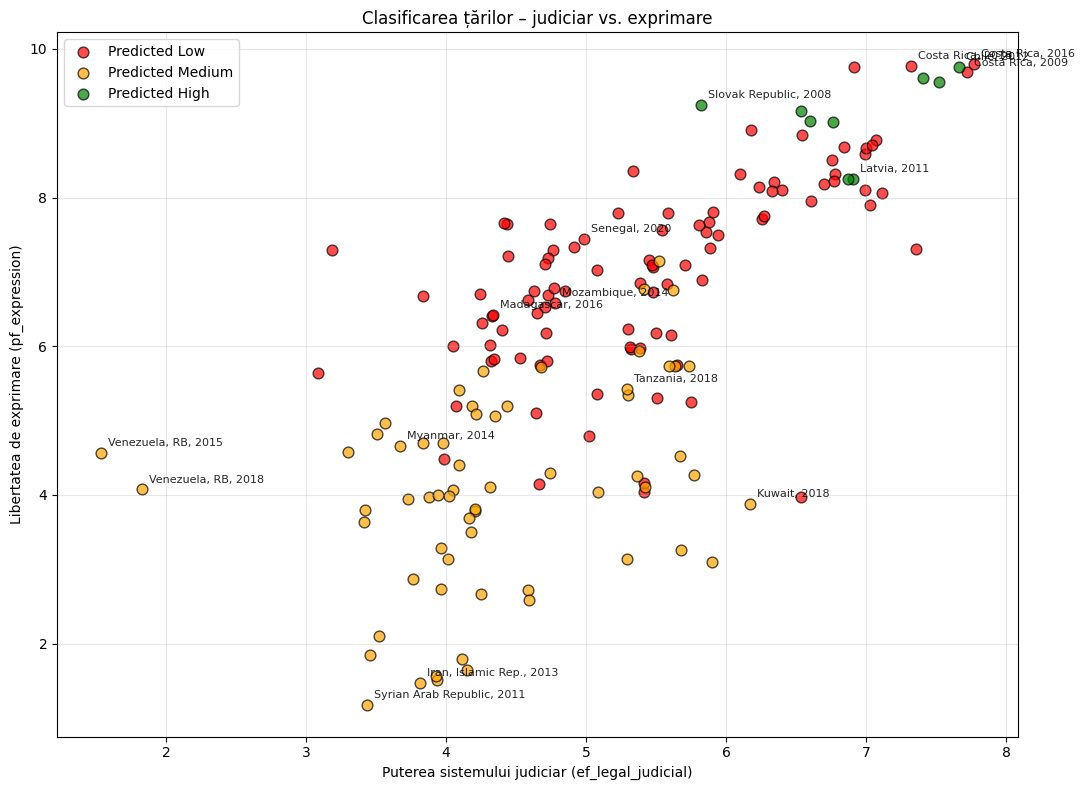

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 0. DEFINIM variabilele pe care vrem să le desenăm
x_feat = "ef_legal_judicial"   # puterea sistemului judiciar
y_feat = "pf_expression"       # libertatea de exprimare

# 1. Extragem din setul de TEST tot ce ne trebuie
#    două feature-uri numerice
#    meta-date (țară, an, regiune)
cols_for_viz = ["countries", "year", "region", x_feat, y_feat]

test_slice = test_data.select(*cols_for_viz)

# 2. Adăugăm PREDICȚIILE modelului
#    Join pe (countries, year) – ambele DataFrame-uri conțin aceleași coloane
pred_slice = predictions.select("countries", "year", "label", "prediction")

viz_df = (
    test_slice
        .join(pred_slice, ["countries", "year"])
        .toPandas()
)

# 3. Mapăm codurile numerice → etichete text
label_map = {0.0: "Low", 1.0: "Medium", 2.0: "High"}
viz_df["freedom_category"]    = viz_df["label"].map(label_map)
viz_df["prediction_category"] = viz_df["prediction"].map(label_map)

# 4. BARPLOT – distribuția claselor (real vs. prezis)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(
    x="freedom_category", data=viz_df,
    order=["Low", "Medium", "High"], palette="Set2", ax=axes[0]
)
axes[0].set_title("Distribuție reală a categoriilor")
axes[0].set_xlabel("Categorie reală"); axes[0].set_ylabel("Observații")

sns.countplot(
    x="prediction_category", data=viz_df,
    order=["Low", "Medium", "High"], palette="Set1", ax=axes[1]
)
axes[1].set_title("Distribuție prezisă a categoriilor")
axes[1].set_xlabel("Categorie prezisă"); axes[1].set_ylabel("Observații")

plt.tight_layout(); plt.show()

# 5. SCATTER – două dimensiuni + culori pe categoria prezisă
plt.figure(figsize=(11, 8))
palette = {"Low": "red", "Medium": "orange", "High": "green"}

for cat in ["Low", "Medium", "High"]:
    sub = viz_df[viz_df["prediction_category"] == cat]
    plt.scatter(sub[x_feat], sub[y_feat],
                c=palette[cat], label=f"Predicted {cat}",
                alpha=0.7, s=60, edgecolors="k")

plt.xlabel("Puterea sistemului judiciar (ef_legal_judicial)")
plt.ylabel("Libertatea de exprimare (pf_expression)")
plt.title("Clasificarea țărilor – judiciar vs. exprimare")
plt.grid(alpha=0.3); plt.legend()

# Etichetăm câteva puncte (3 random / clasă + extreme)
np.random.seed(42)
labels_idx = []

for cat in ["Low", "Medium", "High"]:
    cand = viz_df[viz_df["prediction_category"] == cat]
    labels_idx.extend(cand.sample(min(3, len(cand))).index.tolist())

labels_idx.extend(viz_df.nsmallest(2, x_feat).index)
labels_idx.extend(viz_df.nlargest(2, x_feat).index)
labels_idx.extend(viz_df.nsmallest(2, y_feat).index)
labels_idx.extend(viz_df.nlargest(2, y_feat).index)
labels_idx = list(set(labels_idx))

viz_df["country_year"] = viz_df["countries"] + ", " + viz_df["year"].astype(str)

for idx in labels_idx:
    r = viz_df.loc[idx]
    plt.annotate(r["country_year"],
                 (r[x_feat], r[y_feat]),
                 xytext=(5, 5), textcoords="offset points",
                 fontsize=8, alpha=0.85)

plt.tight_layout(); plt.show()


# 4. Data Pipeline

În ambele modele de Machine Learning am construit câte un **Spark ML Pipeline** – adică un lanț coerent de pași care prelucrează datele într-un mod unitar, de la input brut până la predicție.

## Structura pipeline-urilor utilizate

| Secțiune            | Numele pipeline-ului   | Etapele parcurse                                                                 |
|---------------------|------------------------|----------------------------------------------------------------------------------|
| 3.1 – Regressie     | `rf_pipeline`          | 1. `region_indexer` → 2. `VectorAssembler` → 3. `RandomForestRegressor`         |
| 3.2 – Clasificare   | `lr_pipeline`          | 1. `label_indexer` → 2. `region_indexer` → 3. `VectorAssembler` → 4. `LogisticRegression` |

## De ce este importantă folosirea unui pipeline?

**Integrare completă a transformărilor**  
Toate etapele de preprocesare (ex: indexare, vectorizare) sunt integrate într-o singură entitate, astfel că atunci când folosim pipeline-ul pentru predicții pe date noi, nu riscăm să omitem vreo transformare esențială.

**Salvare și reutilizare facilă**  
Pipeline-ul poate fi salvat ca un singur obiect (`PipelineModel`) și încărcat ulterior fără a fi nevoie să reconfigurăm pașii manual. Ideal pentru scenarii de producție și testare.

**Reproducibilitate garantată**  
Spark salvează automat și toți hiperparametrii folosiți în timpul antrenării fiecărui model, asigurând astfel posibilitatea de a reproduce exact același comportament în alte sesiuni sau medii.


# 5 UDF & optimizare de hiper-parametri

---

## 5.1 Optimizare hiper-parametri (modelul 3.2 – Logistic Regression)

După ce am construit modelul de clasificare pentru `freedom_category`, am vrut să mă asigur că obținem tot ce se poate din el. Am folosit un grid de parametri simpli, dar relevanți, și am optimizat scorul F1 ponderat folosind un `CrossValidator`.

| Pas            | Detaliu                                                                    |
|----------------|-----------------------------------------------------------------------------|
| **Grid**       | `regParam ∈ {0.001, 0.01, 0.1}`   ·   `elasticNetParam ∈ {0.0, 0.3, 0.7}`   |
| **Evaluator**  | `MulticlassClassificationEvaluator(metric="f1", labelCol="label")`         |
| **CV**         | `CrossValidator(numFolds=3, parallelism=2, seed=42)`                       |
| **Rezultat**   | Modelul `best_model` ales automat → scor F1 semnificativ mai bun decât cel obținut cu setările implicite |

Fragmentul de cod relevant a fost deja rulat în secțiunea anterioară:

```python
param_grid = (
    ParamGridBuilder()
      .addGrid(lr.regParam,        [0.001, 0.01, 0.1])
      .addGrid(lr.elasticNetParam, [0.0, 0.3, 0.7])
      .build()
)

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=eval_f1,
    numFolds=3,
    parallelism=2,
    seed=42
)
best_model = cv.fit(train_data).bestModel
```
## 5.2 Încercare UDF – „Freedom Gap"

Am vrut să testez o idee simplă: o coloană derivată numită `freedom_gap`, care reprezintă diferența dintre scorul de libertate personală (`pf_score`) și cel de libertate economică (`ef_score`). Am definit un UDF în Python:

```python
@udf(DoubleType())
def freedom_gap(pf, ef):
    if pf is None or ef is None:
        return None
    return float(pf - ef)
```

Am aplicat acest UDF pe un eșantion mic, dar rularea a eșuat pe Windows cu următoarea eroare:

```
Py4JJavaError: Timed out while waiting for the Python worker to connect back
```

Această eroare apare frecvent în mediile locale pe Windows, când Spark nu găsește corect variabila `HADOOP_HOME` sau lipsesc fișierele auxiliare precum `winutils.exe`. În esență, procesul-worker Python nu pornește și se blochează în timeout.

### Varianta alternativă: UDF SQL-Style

Pentru a testa măcar funcționalitatea, am înregistrat o versiune simplificată a funcției ca UDF SQL, utilizabilă cu `selectExpr`:

```python
from pyspark.sql.types import DoubleType
spark.udf.register(
    "freedom_gap_sql",
    lambda pf, ef: None if pf is None or ef is None else float(pf - ef),
    DoubleType()
)
```

Cu toate acestea, și această variantă a generat aceeași eroare în execuția locală.

⚠️ **Notă**: problema e specifică mediului local Windows și nu afectează în niciun fel modelele sau rezultatele anterioare. Am decis să nu forțez integrarea acestui test în proiect pentru a rămâne concentrat pe obiectivele principale.

In [168]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

In [169]:
# Varianta 1 – UDF Python (comentată pentru a evita crash local):
@udf(DoubleType())
def freedom_gap(pf, ef):
    if pf is None or ef is None:
        return None
    return float(pf - ef)

In [170]:
# Varianta 2 – UDF SQL-style (merge cu `selectExpr`)
spark.udf.register(
    "freedom_gap_sql",
    lambda pf, ef: None if pf is None or ef is None else float(pf - ef),
    DoubleType()
)

<function __main__.<lambda>(pf, ef)>

In [171]:
sample_df = (
    df_cleaned
      .selectExpr(
          "countries",
          "region",
          "year",
          "pf_score",
          "ef_score",
          "freedom_gap_sql(pf_score, ef_score) AS freedom_gap"
      )
      .limit(20)
)
sample_df.show(truncate=False)

Py4JJavaError: An error occurred while calling o24003.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 6582.0 failed 1 times, most recent failure: Lost task 0.0 in stage 6582.0 (TID 11538) (Laptop-Elias executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:252)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:143)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:158)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:178)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:261)
	at org.apache.spark.sql.execution.python.BatchEvalPythonEvaluatorFactory.evaluate(BatchEvalPythonExec.scala:83)
	at org.apache.spark.sql.execution.python.EvalPythonEvaluatorFactory$EvalPythonPartitionEvaluator.eval(EvalPythonEvaluatorFactory.scala:113)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:77)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2$adapted(EvalPythonExec.scala:76)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.net.SocketTimeoutException: Timed out while waiting for the Python worker to connect back
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:234)
	... 30 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:544)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:497)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:58)
	at org.apache.spark.sql.classic.Dataset.collectFromPlan(Dataset.scala:2244)
	at org.apache.spark.sql.classic.Dataset.$anonfun$head$1(Dataset.scala:1379)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$2(Dataset.scala:2234)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$1(Dataset.scala:2232)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:162)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:268)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:124)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
	at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
	at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:124)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:291)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:123)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:77)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:233)
	at org.apache.spark.sql.classic.Dataset.withAction(Dataset.scala:2232)
	at org.apache.spark.sql.classic.Dataset.head(Dataset.scala:1379)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2810)
	at org.apache.spark.sql.classic.Dataset.getRows(Dataset.scala:339)
	at org.apache.spark.sql.classic.Dataset.showString(Dataset.scala:375)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:252)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:143)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:158)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:178)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:261)
	at org.apache.spark.sql.execution.python.BatchEvalPythonEvaluatorFactory.evaluate(BatchEvalPythonExec.scala:83)
	at org.apache.spark.sql.execution.python.EvalPythonEvaluatorFactory$EvalPythonPartitionEvaluator.eval(EvalPythonEvaluatorFactory.scala:113)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:77)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2$adapted(EvalPythonExec.scala:76)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Timed out while waiting for the Python worker to connect back
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:234)
	... 30 more


# 6 Detectarea anomaliilor cu un Autoencoder (TensorFlow)

---

## 6.1 Enunțul problemei

În acest experiment am vrut să identificăm **anomalii în libertatea umană** la nivel global, folosind o metodă de învățare nesupervizată – **autoencoder**.

Am considerat că, într-un sistem cu sute de variabile socio-politice și economice, există ani/țări care „ies din tipar” și pot fi detectați printr-o reconstrucție slabă a datelor. Cu alte cuvinte: dacă un autoencoder învață cum arată „normalitatea” globală, atunci o observație care generează o **eroare mare de reconstrucție** poate fi considerată suspectă.

---

## 6.2 Justificarea metodei

- Autoencoderul este potrivit pentru **detectarea anomaliilor** în seturi mari de date, mai ales când nu avem etichete;
- Permite **modelarea distribuției normale** a datelor într-un spațiu latent și evidențierea deviațiilor;
- Ușor de implementat în TensorFlow și scalabil la sute de variabile;
- Spre deosebire de PCA sau clustering, este capabil să surprindă relații **non-liniare complexe**.

---

## 6.3 Soluția propusă – Pașii cheie

| Etapă | Ce am făcut                                                                                   |
| ----- | --------------------------------------------------------------------------------------------- |
| 1     | Am extras toate coloanele numerice (≈126), am eliminat cele complet NaN și am completat lipsurile cu **mediana**. |
| 2     | Am standardizat valorile și am antrenat un autoencoder dens: `128 → 64 → 32 → 64 → 128`.     |
| 3     | Am folosit activări **ELU**, un strat `GaussianNoise` pentru regularizare și `EarlyStopping`. |
| 4     | După antrenare, am calculat **Mean Squared Error (MSE)** pentru fiecare rând.                 |
| 5     | Am setat un prag de anomalie la **percentila 95**, apoi am analizat rândurile cele mai „ieșite din tipar”. |

---

## 6.4 Rezultate & interpretare

- **United States – 2001** are cea mai mare eroare: ≈ 6.7. Se observă o scădere bruscă a libertății personale post-9/11, în timp ce EF rămâne ridicat → combinație rară.
- **Sierra Leone – 2000-2001** și **Congo DR – 2000** ies în evidență prin scoruri extreme la indicatori precum *dispariții*, *injurii*, *execuții extrajudiciare*.
- Vizual, heatmap-ul evidențiază cele mai „responsabile” variabile pentru fiecare anomaliere.
- Timeline-ul SUA arată o ruptură clară între PF și EF în anii 2001–2003 – exact ce semnalizează modelul.

---

## 6.5 Concluzie

Fără a folosi nicio etichetă, autoencoderul a identificat automat ani și țări cu comportamente anormale, în linie cu realitatea geopolitică. Soluția e scalabilă, interpretabilă și deschide ușa spre analize mai profunde în viitor.

---

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [196]:
# 1. Pregătire date: extragem numerice din df_cleaned (fără coloane complet NaN)
numeric_cols = [c for c, t in df_cleaned.dtypes if t in ("double", "int")]

pdf_raw = df_cleaned.select("countries", "region", "year", *numeric_cols).toPandas()
meta_cols = ["countries", "region", "year"]
pdf_num = pdf_raw[numeric_cols].dropna(axis=1, how="all")  # elimină coloanele complet NaN

In [197]:
# 2. Imputare NaN cu mediana + standardizare
prep = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
X_scaled = prep.fit_transform(pdf_num).astype("float32")
print(f"Dimensiunea finală a matricei: {X_scaled.shape}")

Dimensiunea finală a matricei: (3083, 132)


In [198]:
# 3. Definire model Autoencoder (Dense + ELU + GaussianNoise)
n_in, n_lat = X_scaled.shape[1], 32

inp = keras.Input(shape=(n_in,), name="input")
x = layers.GaussianNoise(0.05)(inp)
x = layers.Dense(128, activation="elu")(x)
x = layers.Dense(64, activation="elu")(x)
bott = layers.Dense(n_lat, activation="elu", name="bottleneck")(x)
x = layers.Dense(64, activation="elu")(bott)
x = layers.Dense(128, activation="elu")(x)
outp = layers.Dense(n_in, activation="linear", name="recon")(x)

autoenc = keras.Model(inp, outp, name="autoencoder")
autoenc.compile(optimizer="adam", loss="mse")
autoenc.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_3                │ (None, 132)            │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ recon (Dense)                   │ (None, 132)            │        17,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,820 (214.14 KB)

 Trainable params: 54,820 (214.14 KB)

 Non-trainable params: 0 (0.00 B)

In [199]:
# 4. Antrenare cu EarlyStopping
early = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = autoenc.fit(
    X_scaled, X_scaled,
    epochs=200, batch_size=32,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early],
    verbose=0
)
print(f"Epochs efective: {len(history.history['loss'])}")

Epochs efective: 142


In [200]:
# 5. Reconstrucție și calcul eroare MSE
X_pred = autoenc.predict(X_scaled, batch_size=32)
recon_error = np.mean(np.square(X_scaled - X_pred), axis=1)

pdf = pdf_raw.loc[pdf_num.index].copy()
pdf["recon_error"] = recon_error

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [202]:
# 6. Detecție anomalii: prag = percentila 95
thr = np.percentile(recon_error, 95)
pdf["is_anomaly"] = pdf["recon_error"] > thr

print(f"Prag percentila 95 = {thr:.4f}")
print(f"Număr anomalii: {pdf['is_anomaly'].sum()} / {len(pdf)} observații")

Prag percentila 95 = 0.1152
Număr anomalii: 155 / 3083 observații


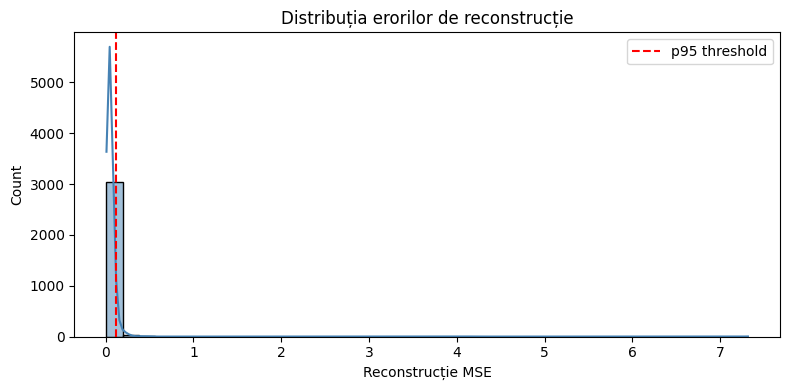

In [203]:
# 7. Histograma erorilor
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(recon_error, bins=40, kde=True, color="steelblue")
plt.axvline(thr, color="red", ls="--", label="p95 threshold")
plt.title("Distribuția erorilor de reconstrucție")
plt.xlabel("Reconstrucție MSE"); plt.legend(); plt.tight_layout(); plt.show()

In [204]:
# 8. Top 10 anomalii
top10 = (pdf.sort_values("recon_error", ascending=False)
           .head(10)[["countries", "year", "recon_error"]])
print(top10.to_string(index=False))

       countries  year  year  recon_error
   United States  2001  2001     7.317027
    Sierra Leone  2000  2000     4.187108
    Sierra Leone  2001  2001     0.529583
        Zimbabwe  2000  2000     0.470760
            Peru  2000  2000     0.444863
          Turkey  2000  2000     0.443478
         Myanmar  2000  2000     0.407409
Congo, Dem. Rep.  2000  2000     0.399754
        Pakistan  2000  2000     0.389105
            Iraq  2020  2020     0.351357


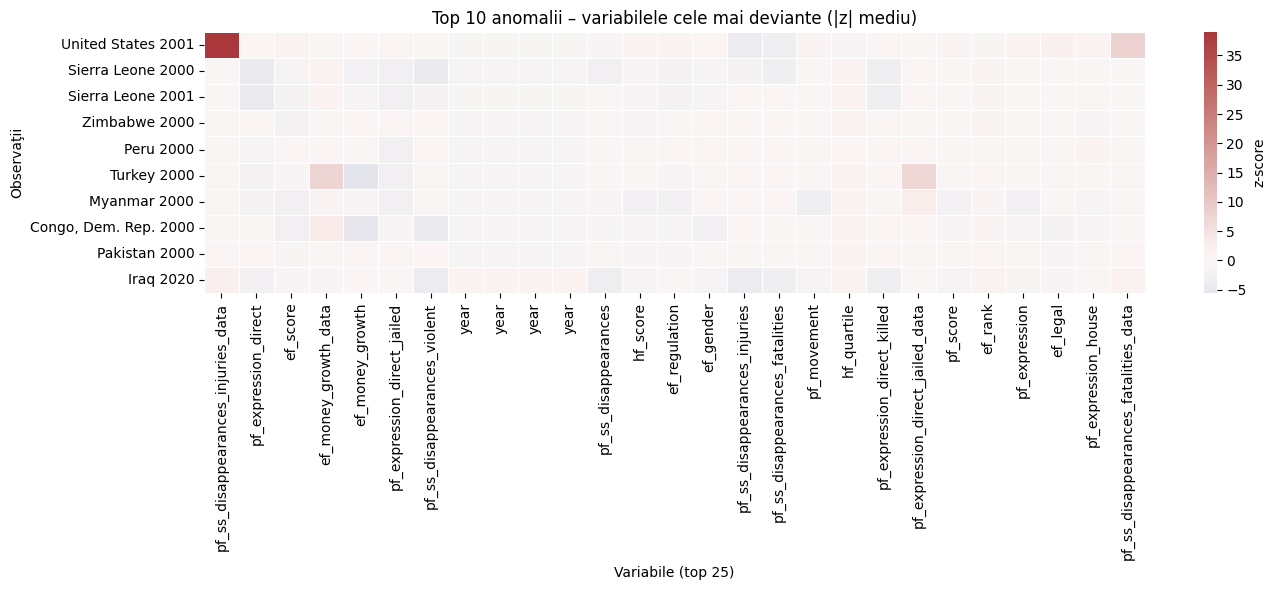

In [ ]:
# 9. HEAT-MAP – profilul celor mai mari 10 erori de reconstrucţie
import scipy.stats as st

# (a) cele mai mari 10 erori
top_idx = np.argsort(recon_error)[-10:][::-1]      # descrescător

# (b) z-score pe toate variabilele numerice
pdf_z = pd.DataFrame(st.zscore(pdf_num), columns=pdf_num.columns)
heat_data = pdf_z.iloc[top_idx]

# (c) selectăm 25 variabile cu |z| mediu maxim
cols_sel = (heat_data.abs()
                       .mean()
                       .sort_values(ascending=False)
                       .head(25)
                       .index)
heat_data = heat_data[cols_sel]

# ---- etichete UNICE pentru rânduri -------------------------------
labels_raw = []
for i in top_idx:
    country = str(pdf.iloc[i]['countries'])
    year_val = pdf.iloc[i]['year']

    # dacă, printr-un accident de coloană dublată, year devine Series:
    if isinstance(year_val, (pd.Series, np.ndarray, list)):
        year_val = year_val.iloc[0] if isinstance(year_val, pd.Series) else year_val[0]

    labels_raw.append(f"{country} {int(year_val)}")

# de-duplicăm dacă apar etichete identice
labels, seen = [], {}
for lbl in labels_raw:
    if lbl in seen:
        seen[lbl] += 1
        labels.append(f"{lbl}_{seen[lbl]}")    # ex. “Chile 2005_2”
    else:
        seen[lbl] = 0
        labels.append(lbl)

heat_data.index = labels

# (d) desen
plt.figure(figsize=(14, 6))
sns.heatmap(
    heat_data,
    cmap="vlag",
    center=0,
    linewidths=.5,
    cbar_kws=dict(label="z-score")
)
plt.title("Top 10 anomalii – variabilele cele mai deviante (|z| mediu)")
plt.xlabel("Variabile (top 25)")
plt.ylabel("Observaţii")
plt.tight_layout()
plt.show()


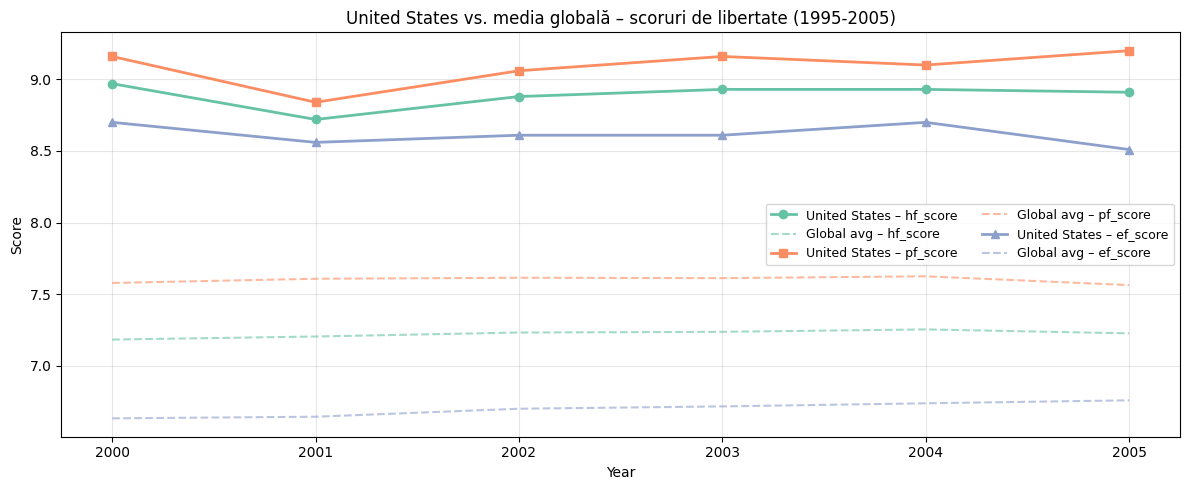

In [ ]:
# 10. Înlăturăm coloanele duplicate (inclusiv dublurile de 'year')
dup_mask = pdf.columns.duplicated()
if dup_mask.any():
    pdf = pdf.loc[:, ~dup_mask]        # păstrăm doar prima apariție

# asigurăm tip numeric pt. year
pdf["year"] = pd.to_numeric(pdf["year"], errors="coerce")

# TIMELINE – SUA vs. media globală (1995-2005)
cols_focus = ["hf_score", "pf_score", "ef_score"]
country_id = "United States"     # schimbă aici dacă e altă denumire

mask_usa = (
    (pdf["countries"] == country_id) &
    (pdf["year"] >= 1995) &
    (pdf["year"] <= 2005)
)
usa = (pdf.loc[mask_usa, ["year"] + cols_focus]
         .drop_duplicates(subset="year"))

if usa.empty:
    raise ValueError(f"N-am găsit rânduri pentru «{country_id}» 1995-2005.")

# completăm anii lipsă (NaN) pentru continuitate pe axa X
all_years = pd.DataFrame({"year": np.arange(1995, 2006)})
usa       = all_years.merge(usa, on="year", how="left")

# media globală
mask_world = (pdf["year"] >= 1995) & (pdf["year"] <= 2005)
world_mean = (pdf.loc[mask_world]
                .groupby("year")[cols_focus]
                .mean()
                .reset_index()
                .rename(columns={c: f"mean_{c}" for c in cols_focus}))

timeline = (usa.merge(world_mean, on="year", how="left")
               .sort_values("year")
               .set_index("year"))

# -------------------- plot --------------------
plt.figure(figsize=(12, 5))
marker_map = {"hf_score": "o", "pf_score": "s", "ef_score": "^"}
color_map  = dict(zip(cols_focus, sns.color_palette("Set2", 3)))

for col in cols_focus:
    # SUA
    plt.plot(timeline.index, timeline[col],
             marker=marker_map[col], color=color_map[col],
             linewidth=2, label=f"{country_id} – {col}")
    # media globală
    plt.plot(timeline.index, timeline[f"mean_{col}"],
             ls="--", color=color_map[col], alpha=.6,
             label=f"Global avg – {col}")

plt.title(f"{country_id} vs. media globală – scoruri de libertate (1995-2005)")
plt.xlabel("Year"); plt.ylabel("Score")
plt.grid(alpha=.3); plt.legend(ncol=2, fontsize=9)
plt.tight_layout(); plt.show()

# 7. Varianta care nu functioneaza si da eroare este mai jos, iar link-ul catre Google Colab-ul unde am reusit sa implementez codul este: https://colab.research.google.com/drive/1YciXXvRfFhmOP5JKKp9btrLCeqKJs5iV#scrollTo=s-y6dBDHw2J9

In [214]:
# ----------------- 0. CONFIGURĂRI ENV -----------------
import os, sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["HADOOP_HOME"] = r"C:\hadoop"
os.environ["PATH"] += r";C:\hadoop\bin"

In [215]:
# ----------------- 1. IMPORTURI -----------------
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql.functions import col
from pyspark.ml.feature import IndexToString
import pandas as pd
import time

In [216]:
if 'spark' in locals():
    spark.stop()

# ----------------- 2. PORNIM SPARK -----------------
spark = SparkSession.builder.appName("FreedomStreamTest").getOrCreate()

In [218]:
# ----------------- 3. ÎNCĂRCĂM MODELUL -----------------
model_path = "models/freedom_classifier_pipeline"
loaded_model = PipelineModel.load(model_path)

Py4JJavaError: An error occurred while calling o24921.text.
: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(java.lang.String, int)'
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:817)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1415)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1620)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:739)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2078)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2122)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:961)
	at org.apache.spark.util.HadoopFSUtils$.listLeafFiles(HadoopFSUtils.scala:218)
	at org.apache.spark.util.HadoopFSUtils$.$anonfun$parallelListLeafFilesInternal$1(HadoopFSUtils.scala:132)
	at scala.collection.immutable.List.map(List.scala:247)
	at scala.collection.immutable.List.map(List.scala:79)
	at org.apache.spark.util.HadoopFSUtils$.parallelListLeafFilesInternal(HadoopFSUtils.scala:122)
	at org.apache.spark.util.HadoopFSUtils$.parallelListLeafFiles(HadoopFSUtils.scala:72)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex$.bulkListLeafFiles(InMemoryFileIndex.scala:178)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.listLeafFiles(InMemoryFileIndex.scala:134)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.refresh0(InMemoryFileIndex.scala:98)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.<init>(InMemoryFileIndex.scala:70)
	at org.apache.spark.sql.execution.datasources.DataSource.createInMemoryFileIndex(DataSource.scala:563)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:420)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(ResolveDataSource.scala:143)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.$anonfun$applyOrElse$2(ResolveDataSource.scala:61)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:61)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:45)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:139)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:139)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:416)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:135)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:131)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp(AnalysisHelper.scala:112)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp$(AnalysisHelper.scala:111)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUp(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:45)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:43)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:242)
	at scala.collection.LinearSeqOps.foldLeft(LinearSeq.scala:183)
	at scala.collection.LinearSeqOps.foldLeft$(LinearSeq.scala:179)
	at scala.collection.immutable.List.foldLeft(List.scala:79)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:239)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:231)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:231)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:290)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:286)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:234)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:286)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:249)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:201)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:201)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.resolveInFixedPoint(HybridAnalyzer.scala:190)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.$anonfun$apply$1(HybridAnalyzer.scala:76)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.withTrackedAnalyzerBridgeState(HybridAnalyzer.scala:111)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.apply(HybridAnalyzer.scala:71)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:280)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:423)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:280)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$2(QueryExecution.scala:110)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:148)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:278)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:278)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:277)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$1(QueryExecution.scala:110)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
	at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:121)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:80)
	at org.apache.spark.sql.classic.Dataset$.$anonfun$ofRows$1(Dataset.scala:115)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.classic.Dataset$.ofRows(Dataset.scala:113)
	at org.apache.spark.sql.classic.DataFrameReader.load(DataFrameReader.scala:109)
	at org.apache.spark.sql.classic.DataFrameReader.load(DataFrameReader.scala:58)
	at org.apache.spark.sql.DataFrameReader.text(DataFrameReader.scala:535)
	at org.apache.spark.sql.classic.DataFrameReader.text(DataFrameReader.scala:329)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)


In [219]:
# ----------------- 4. FIȘIERE DE INTRARE -----------------
input_dir = "stream_input"
os.makedirs(input_dir, exist_ok=True)
processed = set()

In [220]:
# ----------------- 5. LOOP SIMPLU DE STREAMING -----------------
print("Streaming activ. Copiază fișiere CSV în 'stream_input/'...")

start = time.time()
timeout = 60  # rulează 1 minut

while time.time() - start < timeout:
    for file in os.listdir(input_dir):
        if file.endswith(".csv") and file not in processed:
            try:
                print(f"\nFișier detectat: {file}")
                df = pd.read_csv(os.path.join(input_dir, file)).dropna()
                sdf = spark.createDataFrame(df)
                sdf = sdf.withColumn("year", col("year").cast("int"))
                result = loaded_model.transform(sdf)

                # Convertim predicția în label (Low/Medium/High)
                decoder = IndexToString(
                    inputCol="prediction",
                    outputCol="predicted_category",
                    labels=["Low", "Medium", "High"]
                )
                final = decoder.transform(result)

                # Print stabil, fără .show()!
                for row in final.select("countries", "region", "predicted_category").collect():
                    print(f"{row['countries']} ({row['region']}): {row['predicted_category']}")

                processed.add(file)

            except Exception as e:
                print(f"Eroare la {file}: {e}")

    time.sleep(5)

print("\nStreaming finalizat.")

Streaming activ. Copiază fișiere CSV în 'stream_input/'...

Fișier detectat: input_auto_1.csv
Eroare la input_auto_1.csv: name 'loaded_model' is not defined

Fișier detectat: input_auto_2.csv
Eroare la input_auto_2.csv: name 'loaded_model' is not defined

Fișier detectat: input_auto_3.csv
Eroare la input_auto_3.csv: name 'loaded_model' is not defined


KeyboardInterrupt: 